In [1]:
# import pytorch libraries
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.deprecation import deprecated

import os
import csv
import copy
import math
import time
import random
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tools.eval_measures import mse
from decimal import Decimal
from scipy import stats
from scipy.stats import spearmanr, rankdata, norm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

### generate significant variant txt file

In [17]:
# find significant ones in cmd
# cd /project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/Test_GTEx_fastQTL_results/
# zcat Brain_Amygdala.v8.allpairs.txt.gz | awk '{ if ($7 < 0.0001) print }' > Our_GTEx_Amygdala.0.0001.variant.txt

data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/Test_GTEx_fastQTL_results/'
# read the genes with pval_nominal_threshold file
filename = 'Brain_Amygdala.v8.genes.txt.gz'
our_gtex_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
# read the variant with pval_nominal file (after 0.0001 threshold)
filename = 'Our_GTEx_Amygdala.0.0001.variant.txt'
column_names = ['gene_id', 'variant_id', 'tss_distance', 'ma_samples', 'ma_count', 'maf', 'pval_nominal', 'slope', 'slope_se']
our_var = pd.read_csv(data_dir+filename, delimiter='\t', names=column_names)

our_gtex_egene_sub = our_gtex_egene[['gene_id', 'pval_nominal_threshold', 'pval_nominal', 'pval_beta']]
col_name = ['gene_id', 'pval_nominal_threshold', 'min_pval_nominal', 'pval_beta']
our_gtex_egene_sub.columns = col_name
# left merge the gene file to the variant file
our_gtex_var_gene = our_var.merge(our_gtex_egene_sub, on='gene_id', how='left')
# filter out those variant with a pval<pval_threshold
our_gtex_sig_var_gene = our_gtex_var_gene.loc[our_gtex_var_gene['pval_nominal']<our_gtex_var_gene['pval_nominal_threshold']]
our_gtex_sig_var_gene = our_gtex_sig_var_gene.reset_index(drop=True)

In [18]:
our_gtex_sig_var_gene

,gene_id,variant_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se,pval_nominal_threshold,min_pval_nominal,pval_beta
0,ENSG00000279457.4,chr1_181113_A_G_b38,-14298,94,99,0.396000,2.081650e-07,-0.799995,0.143831,0.000006,8.183610e-11,2.632420e-07
1,ENSG00000279457.4,chr1_182095_T_C_b38,-13316,100,112,0.444444,4.797740e-06,-0.742849,0.153930,0.000006,8.183610e-11,2.632420e-07
2,ENSG00000279457.4,chr1_182903_C_G_b38,-12508,99,107,0.417969,2.147040e-08,-0.860904,0.141923,0.000006,8.183610e-11,2.632420e-07
3,ENSG00000279457.4,chr1_185194_G_C_b38,-10217,112,113,0.437984,6.679050e-08,-1.156120,0.198758,0.000006,8.183610e-11,2.632420e-07
4,ENSG00000279457.4,chr1_185428_A_G_b38,-9983,109,111,0.430233,5.590710e-09,-1.134130,0.178435,0.000006,8.183610e-11,2.632420e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
371972,ENSG00000182484.15,chrX_156021624_CAGG_C_b38,798,84,84,0.325581,2.408000e-16,1.282790,0.131537,0.000018,9.604850e-19,9.966920e-16
371973,ENSG00000182484.15,chrX_156024891_C_T_b38,4065,95,95,0.368217,1.821620e-18,1.472250,0.137571,0.000018,9.604850e-19,9.966920e-16
371974,ENSG00000182484.15,chrX_156025024_C_T_b38,4198,98,98,0.379845,9.604850e-19,1.526510,0.140999,0.000018,9.604850e-19,9.966920e-16
371975,ENSG00000182484.15,chrX_156025116_G_A_b38,4290,92,92,0.356589,8.559680e-16,1.431200,0.150563,0.000018,9.604850e-19,9.966920e-16


In [4]:
# raed GTEx egene.txt
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/GTEx_Analysis_v8_eQTL/'
filename = 'Brain_Amygdala.v8.egenes.txt.gz'
GTEx_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')

# read the GTEx significant variant gene pairs
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/GTEx_Analysis_v8_eQTL/'
filename = 'Brain_Amygdala.v8.signif_variant_gene_pairs.txt.gz'
gtex_sig_var_gene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')

In [5]:
# our_gtex_sig_var_gene.loc[our_gtex_sig_var_gene['gene_id']=='ENSG00000237973.1']
# gtex_sig_var_gene_df.loc[gtex_sig_var_gene_df['gene_id']=='ENSG00000237973.1']

print('In our new generated sig-var-gene pairs GTEx results:')
print(f'  - {len(our_gtex_sig_var_gene)} significant variant-gene pairs')
print(f'  - {len(set(our_gtex_sig_var_gene["gene_id"]))} unique genes')
print(f'  - {len(set(our_gtex_sig_var_gene["variant_id"]))} unique variants')
print('In sig-var-gene pairs from GTEx portal:')
print(f'  - {len(gtex_sig_var_gene)} significant variant-gene pairs')
print(f'  - {len(set(gtex_sig_var_gene["gene_id"]))} unique genes')
print(f'  - {len(set(gtex_sig_var_gene["variant_id"]))} unique variants')

In our new generated sig-var-gene pairs GTEx results:
  - 371977 significant variant-gene pairs
  - 4314 unique genes
  - 243195 unique variants
In sig-var-gene pairs from GTEx portal:
  - 347359 significant variant-gene pairs
  - 3725 unique genes
  - 241588 unique variants


In [20]:
merge_df = pd.merge(our_gtex_sig_var_gene, gtex_sig_var_gene, on=['gene_id', 'variant_id', 'tss_distance', 'ma_samples', 'ma_count', 'maf'], how='inner')
len(merge_df.loc[merge_df['pval_nominal_x']==merge_df['pval_nominal_y']])
    
print("If we want these columns to be the same: ['gene_id', 'variant_id', 'tss_distance', 'ma_samples', 'ma_count', 'maf']")
print(f"  - {len(merge_df)} significant variant-gene pairs in common:")
print(f"  - {len(merge_df.loc[merge_df['pval_nominal_x']==merge_df['pval_nominal_y']])} of them have the same pval_nominal")
print(f"  - {len(merge_df.loc[merge_df['slope_x']==merge_df['slope_y']])} of them have the same slope")
print(f"  - {len(set(merge_df['gene_id']))} unique genes")
print(f"  - {len(set(merge_df['variant_id']))} unique variants")

If we want these columns to be the same: ['gene_id', 'variant_id', 'tss_distance', 'ma_samples', 'ma_count', 'maf']
  - 232494 significant variant-gene pairs in common:
  - 232176 of them have the same pval_nominal
  - 232176 of them have the same slope
  - 2993 unique genes
  - 163945 unique variants


In [21]:
# merge_df = pd.merge(our_gtex_sig_var_gene, gtex_sig_var_gene, on=['gene_id', 'variant_id', 'tss_distance', 'ma_samples', 'ma_count', 'maf'], how='inner')
merge_df = pd.merge(our_gtex_sig_var_gene, gtex_sig_var_gene, on=['gene_id', 'variant_id'], how='inner')
diff_merge_df = merge_df.loc[(merge_df['ma_samples_x']!=merge_df['ma_samples_y']) | (merge_df['ma_count_x']!=merge_df['ma_count_y']) | (merge_df['maf_x']!=merge_df['maf_y'])]

print(f"For {len(diff_merge_df)} significant variant gene pairs that have the same ['gene_id', 'variant_id']\n but different ['tss_distance', 'ma_samples', 'ma_count', 'maf']")
print(f"  - {len(diff_merge_df.loc[diff_merge_df['pval_nominal_x']==diff_merge_df['pval_nominal_y']])} of them have the same pval_nominal")
print(f"  - {len(diff_merge_df.loc[diff_merge_df['slope_x']==diff_merge_df['slope_y']])} of them have the same slope")
print(f"  - {len(set(diff_merge_df['gene_id']))} unique genes")
print(f"  - {len(set(diff_merge_df['variant_id']))} unique variants")

For 29656 significant variant gene pairs that have the same ['gene_id', 'variant_id']
 but different ['tss_distance', 'ma_samples', 'ma_count', 'maf']
  - 11 of them have the same pval_nominal
  - 12 of them have the same slope
  - 1991 unique genes
  - 18980 unique variants


In [8]:
diff_merge_df

,gene_id,variant_id,tss_distance_x,ma_samples_x,ma_count_x,maf_x,pval_nominal_x,slope_x,slope_se_x,pval_nominal_threshold_x,...,tss_distance_y,ma_samples_y,ma_count_y,maf_y,pval_nominal_y,slope_y,slope_se_y,pval_nominal_threshold_y,min_pval_nominal_y,pval_beta_y
7,ENSG00000237973.1,chr1_1248141_G_C_b38,617067,7,9,0.035714,4.387800e-07,0.844813,0.156683,0.000004,...,617067,3,5,0.022936,3.216310e-09,1.233070,0.190477,0.000028,3.216310e-09,4.503890e-06
39,ENSG00000225880.5,chr1_758443_G_C_b38,-69079,32,35,0.135659,1.198180e-06,0.699531,0.135615,0.000004,...,-69079,33,35,0.135659,6.455960e-07,0.734578,0.138529,0.000027,7.818510e-10,1.052000e-06
46,ENSG00000225880.5,chr1_818094_C_G_b38,-9428,50,54,0.209302,9.433070e-07,-0.692919,0.132887,0.000004,...,-9428,50,55,0.213178,4.411080e-07,-0.680199,0.126181,0.000027,7.818510e-10,1.052000e-06
50,ENSG00000225880.5,chr1_823246_C_T_b38,-4276,42,45,0.174419,1.242000e-06,-0.651218,0.126456,0.000004,...,-4276,37,38,0.154472,3.200620e-06,-0.717119,0.145634,0.000027,7.818510e-10,1.052000e-06
51,ENSG00000225880.5,chr1_824320_T_C_b38,-3202,47,49,0.189922,2.462930e-09,-0.810638,0.124139,0.000004,...,-3202,45,47,0.188000,2.290040e-09,-0.827768,0.126465,0.000027,7.818510e-10,1.052000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262100,ENSG00000277203.1,chrX_155711501_CT_C_b38,825152,46,48,0.186047,4.004360e-11,-0.911331,0.123459,0.000010,...,825152,47,49,0.189922,2.475860e-12,-0.934947,0.117736,0.000064,8.163560e-14,7.896140e-11
262101,ENSG00000277203.1,chrX_155711505_G_C_b38,825156,46,48,0.186047,4.004360e-11,-0.911331,0.123459,0.000010,...,825156,47,49,0.189922,2.475860e-12,-0.934947,0.117736,0.000064,8.163560e-14,7.896140e-11
262102,ENSG00000277203.1,chrX_155711858_A_G_b38,825509,46,48,0.186047,2.898400e-11,-0.892546,0.119851,0.000010,...,825509,47,49,0.189922,2.475860e-12,-0.934947,0.117736,0.000064,8.163560e-14,7.896140e-11
262133,ENSG00000277203.1,chrX_155734993_T_A_b38,848644,95,105,0.406977,8.193380e-09,-0.719876,0.114736,0.000010,...,848644,95,104,0.403101,4.279040e-09,-0.754481,0.117649,0.000064,8.163560e-14,7.896140e-11


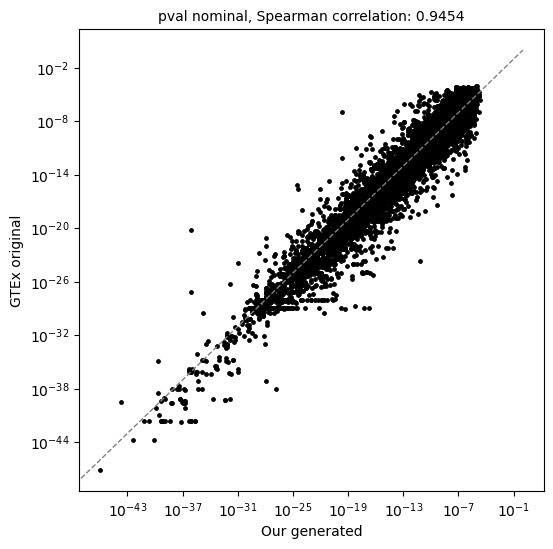

In [9]:
our_pval = diff_merge_df['pval_nominal_x']
gtex_pval = diff_merge_df['pval_nominal_y']
lim_range = 1

corr, p = spearmanr(our_pval, gtex_pval)

plt.figure(figsize=(6, 6))
plt.scatter(our_pval, gtex_pval, color='black', marker='o', s=6)
plt.plot([-lim_range, lim_range], [-lim_range, lim_range], linestyle='--', color='grey', linewidth=1)

plt.title(f'pval nominal, Spearman correlation: {corr:.4f}', fontsize=10)
plt.xlabel('Our generated', fontsize=10)
plt.ylabel('GTEx original', fontsize=10)
# plt.xlim(0, lim_range)
# plt.ylim(0, lim_range)
plt.grid(False)
plt.xscale('log')
plt.yscale('log')

plt.show()

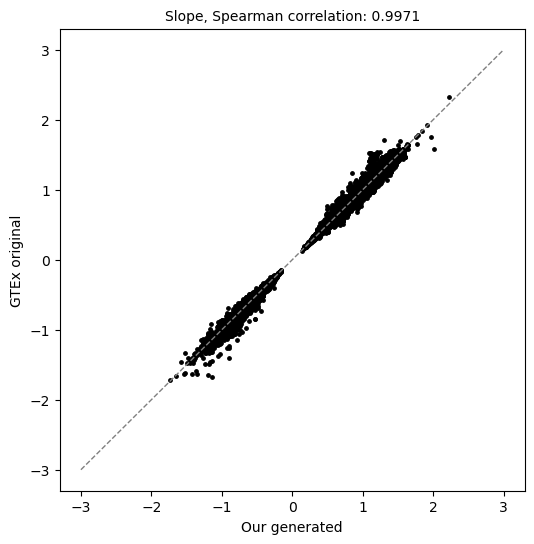

In [10]:
our_slope = diff_merge_df['slope_x']
gtex_slope = diff_merge_df['slope_y']
lim_range = 3

corr, p = spearmanr(our_slope, gtex_slope)

plt.figure(figsize=(6, 6))
plt.scatter(our_slope, gtex_slope, color='black', marker='o', s=6)
plt.plot([-lim_range, lim_range], [-lim_range, lim_range], linestyle='--', color='grey', linewidth=1)

plt.title(f'Slope, Spearman correlation: {corr:.4f}', fontsize=10)
plt.xlabel('Our generated', fontsize=10)
plt.ylabel('GTEx original', fontsize=10)
# plt.xlim(0, lim_range)
# plt.ylim(0, lim_range)
plt.grid(False)

plt.show()

### Fastqtl with our bed.gz file with more subjects

In [9]:
region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
               'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
               'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']
pick_threshold = 0.00015
end = True
for region in region_pick:
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'
    filename = region + '.genes.txt.gz'
    our_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
    if max(our_egene['pval_nominal_threshold'])>=pick_threshold:
        end = False
        print(f"{region} didn't pass the threshold {pick_threshold}")
if end==True:
    print(f'All the regions passed the picked threshold {pick_threshold}!')

All the regions passed the picked threshold 0.00015!


In [26]:
# # generate significant variant-gene pairs for GTEx regions
# region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
#                'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
#                'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']
# data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'

# for region in region_pick:
#     # read the files
#     filename = region + '.genes.txt.gz'
#     our_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
#     threshold = '0.0001'
#     if region=='Cerebellar_Hemisphere':
#         threshold = '0.00015'
#     filename = region + '.' + threshold + '.variant.txt'
#     column_names = ['gene_id', 'variant_id', 'tss_distance', 'ma_samples', 'ma_count', 'maf', 'pval_nominal', 'slope', 'slope_se']
#     our_var = pd.read_csv(data_dir+filename, delimiter='\t', names=column_names)
#     # build our significant variant-gene pairs file
#     our_egene_sub = our_egene[['gene_id', 'pval_nominal_threshold', 'pval_nominal', 'pval_beta']]
#     col_name = ['gene_id', 'pval_nominal_threshold', 'min_pval_nominal', 'pval_beta']
#     our_egene_sub.columns = col_name
#     # left merge the gene file to the variant file
#     our_var_gene = our_var.merge(our_egene_sub, on='gene_id', how='left')
#     # filter out those variant with a pval<pval_threshold
#     our_sig_var_gene = our_var_gene.loc[our_var_gene['pval_nominal']<our_var_gene['pval_nominal_threshold']]
#     our_sig_var_gene = our_sig_var_gene.reset_index(drop=True)
#     our_sig_var_gene.to_csv(data_dir+region+'.sig-gene-variant.csv', index=False)

In [23]:
# find significant ones in cmd
# module load miniconda/22.11.1-1
# conda activate fastqtl_env
# cd /project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/
# zcat Amygdala.allpairs.txt.gz | awk '{ if ($7 < 0.01) print }' > Amygdala.0.01.variant.txt
# zcat Amygdala.allpairs.txt.gz | awk '{ if ($7 < 0.0001) print }' > Amygdala.0.0001.variant.txt
# zcat Cerebellar_Hemisphere.allpairs.txt.gz | awk '{ if ($7 < 0.00015) print }' > Cerebellar_Hemisphere.0.00015.variant.txt
# region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
#                'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
#                'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']

# our gene.txt
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'
filename = 'Amygdala.genes.txt.gz'
our_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
# our variants with pval_nomial<0.0001
filename = 'Amygdala.0.0001.variant.txt'
column_names = ['gene_id', 'variant_id', 'tss_distance', 'ma_samples', 'ma_count', 'maf', 'pval_nominal', 'slope', 'slope_se']
our_var = pd.read_csv(data_dir+filename, delimiter='\t', names=column_names)
# build our significant variant-gene pairs file
our_egene_sub = our_egene[['gene_id', 'pval_nominal_threshold', 'pval_nominal', 'pval_beta']]
col_name = ['gene_id', 'pval_nominal_threshold', 'min_pval_nominal', 'pval_beta']
our_egene_sub.columns = col_name
# left merge the gene file to the variant file
our_var_gene = our_var.merge(our_egene_sub, on='gene_id', how='left')
# filter out those variant with a pval<pval_threshold
our_sig_var_gene = our_var_gene.loc[our_var_gene['pval_nominal']<our_var_gene['pval_nominal_threshold']]
our_sig_var_gene = our_sig_var_gene.reset_index(drop=True)
# our_sig_var_gene.to_csv(data_dir+'Amygdala.sig-gene-variant.csv', index=False)

# raed GTEx egene.txt
# note: here we compare our results with the original GTEx results, not the reproduced version results!!!!
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/GTEx_Analysis_v8_eQTL/'
filename = 'Brain_Amygdala.v8.egenes.txt.gz'
GTEx_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
# read the GTEx significant variant gene pairs
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/GTEx_Analysis_v8_eQTL/'
filename = 'Brain_Amygdala.v8.signif_variant_gene_pairs.txt.gz'
gtex_sig_var_gene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')

In [20]:
our_sig_var_gene

,gene_id,variant_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se,pval_nominal_threshold,min_pval_nominal,pval_beta
0,ENSG00000225880.5,chr1_726821_G_A_b38,-100701,57,70,0.178571,8.745250e-06,-0.415227,0.090336,0.000010,1.865120e-12,1.381140e-08
1,ENSG00000225880.5,chr1_758351_A_G_b38,-69171,50,54,0.136364,6.633230e-06,0.498381,0.106914,0.000010,1.865120e-12,1.381140e-08
2,ENSG00000225880.5,chr1_758443_G_C_b38,-69079,51,54,0.136364,4.091220e-06,0.522681,0.109490,0.000010,1.865120e-12,1.381140e-08
3,ENSG00000225880.5,chr1_761341_G_A_b38,-66181,16,16,0.040404,5.495830e-07,0.992197,0.189987,0.000010,1.865120e-12,1.381140e-08
4,ENSG00000225880.5,chr1_762507_G_C_b38,-65015,17,17,0.042929,3.268390e-08,1.048240,0.180280,0.000010,1.865120e-12,1.381140e-08
...,...,...,...,...,...,...,...,...,...,...,...,...
420151,ENSG00000185973.10,chrX_155717737_C_T_b38,47793,67,69,0.174242,2.626050e-06,0.440058,0.090264,0.000034,1.063040e-07,2.590420e-04
420152,ENSG00000185973.10,chrX_155718194_GC_G_b38,48250,67,69,0.174242,2.626050e-06,0.440058,0.090264,0.000034,1.063040e-07,2.590420e-04
420153,ENSG00000185973.10,chrX_155720291_C_G_b38,50347,68,70,0.176768,4.344270e-06,0.431867,0.090730,0.000034,1.063040e-07,2.590420e-04
420154,ENSG00000185973.10,chrX_155720450_G_A_b38,50506,160,184,0.464646,4.906820e-06,0.423799,0.089565,0.000034,1.063040e-07,2.590420e-04


In [37]:
print('Region: Amygdala')

print(f'  - Our analysis includes {len(our_egene)} genes')
print(f'  - GTE analysis includes {len(GTEx_egene)} genes')

print(f'In our sig-var-gene pairs:')
print(f'  - {len(our_sig_var_gene)} significant variant-gene pairs')
print(f'  - {len(set(our_sig_var_gene["gene_id"]))} unique genes')
print(f'  - {len(set(our_sig_var_gene["variant_id"]))} unique variants')
print('In sig-var-gene pairs from GTEx portal:')
print(f'  - {len(gtex_sig_var_gene)} significant variant-gene pairs')
print(f'  - {len(set(gtex_sig_var_gene["gene_id"]))} unique genes')
print(f'  - {len(set(gtex_sig_var_gene["variant_id"]))} unique variants')

Region: Amygdala
  - Our analysis includes 15028 genes
  - GTE analysis includes 24069 genes
In our sig-var-gene pairs:
  - 420156 significant variant-gene pairs
  - 5369 unique genes
  - 322109 unique variants
In sig-var-gene pairs from GTEx portal:
  - 347359 significant variant-gene pairs
  - 3725 unique genes
  - 241588 unique variants


In [49]:
overlapped_gene = list(set(our_egene['gene_id']) & set(GTEx_egene['gene_id']))
our_sig_var_gene_sub = our_sig_var_gene.loc[our_sig_var_gene['gene_id'].isin(overlapped_gene)].reset_index(drop=True)
gtex_sig_var_gene_sub = gtex_sig_var_gene.loc[gtex_sig_var_gene['gene_id'].isin(overlapped_gene)].reset_index(drop=True)

print(f"There are {len(overlapped_gene)} overlapped genes")
print(f"If we only look at those significant variant-gene pairs related to these overlapped genes:")
print(f'In our sig-var-gene pairs:')
print(f'  - {len(our_sig_var_gene_sub)} significant variant-gene pairs')
print(f'  - {len(set(our_sig_var_gene_sub["variant_id"]))} unique variants')
print('In sig-var-gene pairs from GTEx portal:')
print(f'  - {len(gtex_sig_var_gene_sub)} significant variant-gene pairs')
print(f'  - {len(set(gtex_sig_var_gene_sub["variant_id"]))} unique variants')

There are 14796 overlapped genes
If we only look at those significant variant-gene pairs related to these overlapped genes:
In our sig-var-gene pairs:
  - 418836 significant variant-gene pairs
  - 320921 unique variants
In sig-var-gene pairs from GTEx portal:
  - 171983 significant variant-gene pairs
  - 142813 unique variants


In [54]:
merge_df = pd.merge(our_sig_var_gene_sub, gtex_sig_var_gene_sub, on=['gene_id', 'variant_id', 'tss_distance'], how='inner')

print(f"Variant-gene pairs related to {len(overlapped_gene)} overlapped genes:")
print(f"Number of var-gene pairs: Us: {len(our_sig_var_gene_sub)}; GTEx: {len(gtex_sig_var_gene_sub)}")
print(f"  - Appear in both: {len(merge_df)}")

Variant-gene pairs related to 14796 overlapped genes:
Number of var-gene pairs: Us: 418836; GTEx: 171983
  - Appear in both: 154624


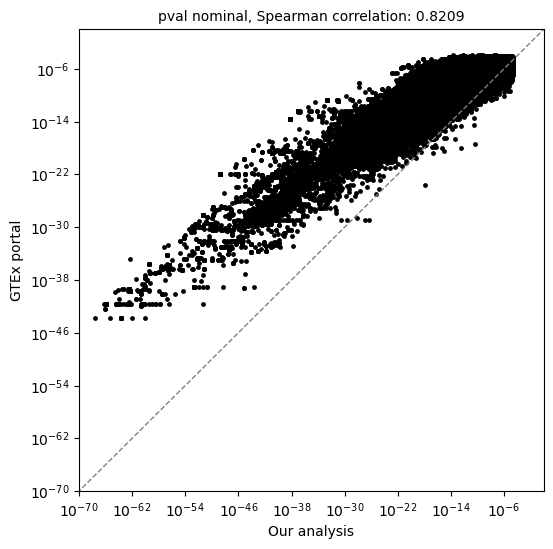

In [65]:
our_pval = merge_df['pval_nominal_x']
gtex_pval = merge_df['pval_nominal_y']
lim_range = 1

corr, p = spearmanr(our_pval, gtex_pval)

plt.figure(figsize=(6, 6))
plt.scatter(our_pval, gtex_pval, color='black', marker='o', s=6)
plt.plot([-lim_range, lim_range], [-lim_range, lim_range], linestyle='--', color='grey', linewidth=1)

plt.title(f'pval nominal, Spearman correlation: {corr:.4f}', fontsize=10)
plt.xlabel('Our analysis', fontsize=10)
plt.ylabel('GTEx portal', fontsize=10)
plt.xlim(1e-70, 1e-0)
plt.ylim(1e-70, 1e-0)
plt.grid(False)
plt.xscale('log')
plt.yscale('log')

plt.show()

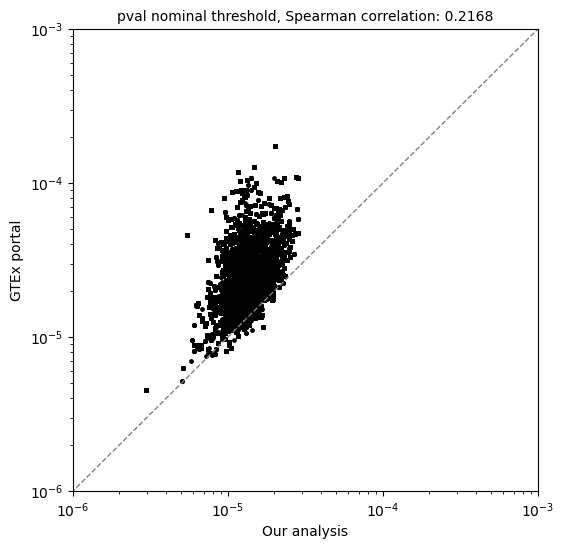

In [72]:
our_pval_threshold = merge_df['pval_nominal_threshold_x']
gtex_pval_threshold = merge_df['pval_nominal_threshold_y']
lim_range = 1

corr, p = spearmanr(our_pval_threshold, gtex_pval_threshold)

plt.figure(figsize=(6, 6))
plt.scatter(our_pval_threshold, gtex_pval_threshold, color='black', marker='o', s=6)
plt.plot([-lim_range, lim_range], [-lim_range, lim_range], linestyle='--', color='grey', linewidth=1)

plt.title(f'pval nominal threshold, Spearman correlation: {corr:.4f}', fontsize=10)
plt.xlabel('Our analysis', fontsize=10)
plt.ylabel('GTEx portal', fontsize=10)
plt.xlim(1e-6, 1e-3)
plt.ylim(1e-6, 1e-3)
plt.grid(False)
plt.xscale('log')
plt.yscale('log')

plt.show()

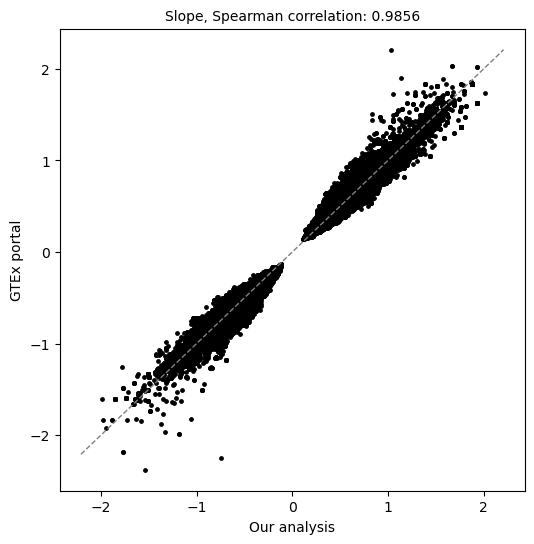

In [69]:
our_slope = merge_df['slope_x']
gtex_slope = merge_df['slope_y']
lim_range = max([max(our_slope), max(gtex_slope)])

corr, p = spearmanr(our_slope, gtex_slope)

plt.figure(figsize=(6, 6))
plt.scatter(our_slope, gtex_slope, color='black', marker='o', s=6)
plt.plot([-lim_range, lim_range], [-lim_range, lim_range], linestyle='--', color='grey', linewidth=1)

plt.title(f'Slope, Spearman correlation: {corr:.4f}', fontsize=10)
plt.xlabel('Our analysis', fontsize=10)
plt.ylabel('GTEx portal', fontsize=10)
#plt.xlim(1e-70, 1e-0)
#plt.ylim(1e-70, 1e-0)
plt.grid(False)

plt.show()

In [55]:
merge_df

,gene_id,variant_id,tss_distance,ma_samples_x,ma_count_x,maf_x,pval_nominal_x,slope_x,slope_se_x,pval_nominal_threshold_x,...,pval_beta_x,ma_samples_y,ma_count_y,maf_y,pval_nominal_y,slope_y,slope_se_y,pval_nominal_threshold_y,min_pval_nominal_y,pval_beta_y
0,ENSG00000225880.5,chr1_758351_A_G_b38,-69171,50,54,0.136364,6.633230e-06,0.498381,0.106914,0.000010,...,1.381140e-08,32,35,0.135659,1.198180e-06,0.699531,0.135615,0.000027,7.818510e-10,1.052000e-06
1,ENSG00000225880.5,chr1_758443_G_C_b38,-69079,51,54,0.136364,4.091220e-06,0.522681,0.109490,0.000010,...,1.381140e-08,33,35,0.135659,6.455960e-07,0.734578,0.138529,0.000027,7.818510e-10,1.052000e-06
2,ENSG00000225880.5,chr1_777550_T_C_b38,-49972,19,19,0.047980,5.801280e-08,0.983130,0.172563,0.000010,...,1.381140e-08,15,15,0.058139,5.157310e-06,0.952030,0.197999,0.000027,7.818510e-10,1.052000e-06
3,ENSG00000225880.5,chr1_777751_A_AT_b38,-49771,19,19,0.047980,5.801280e-08,0.983130,0.172563,0.000010,...,1.381140e-08,15,15,0.058139,5.157310e-06,0.952030,0.197999,0.000027,7.818510e-10,1.052000e-06
4,ENSG00000225880.5,chr1_778534_A_G_b38,-48988,19,19,0.047980,5.801280e-08,0.983130,0.172563,0.000010,...,1.381140e-08,15,15,0.058139,5.157310e-06,0.952030,0.197999,0.000027,7.818510e-10,1.052000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154619,ENSG00000277203.1,chrX_155746162_ATTC_A_b38,859813,14,14,0.035354,1.073790e-05,-1.006900,0.221405,0.000021,...,6.497640e-17,11,11,0.042636,3.399620e-05,-1.061820,0.245040,0.000064,8.163560e-14,7.896140e-11
154620,ENSG00000277203.1,chrX_155746397_G_A_b38,860048,154,180,0.454545,4.134980e-11,-0.644131,0.090804,0.000021,...,6.497640e-17,101,114,0.441860,1.210280e-07,-0.673782,0.118536,0.000064,8.163560e-14,7.896140e-11
154621,ENSG00000277203.1,chrX_155747288_G_A_b38,860939,16,16,0.040404,5.845900e-07,-1.080090,0.207350,0.000021,...,6.497640e-17,12,12,0.046512,1.749400e-06,-1.195540,0.235864,0.000064,8.163560e-14,7.896140e-11
154622,ENSG00000277203.1,chrX_155747786_G_A_b38,861437,14,14,0.035354,1.073790e-05,-1.006900,0.221405,0.000021,...,6.497640e-17,11,11,0.042636,3.399620e-05,-1.061820,0.245040,0.000064,8.163560e-14,7.896140e-11


### Analysis 10 GTEx region sig-gene-variant pairs (our results v.s. original results)

In [14]:
region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
               'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
               'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']

col_name = ['Region', '#gene', '#gene in GTEx', '#intersected genes', '#var', '#var in GTEx', '#intersected var', '#var-gene-pairs(cgene)', '#var-gene in GTEx(cgene)', '#intersected pairs', 'slope correlation']
e1, e2 = [], []
s1, s2 = [], []
l1, l2, l3, l4, l5, l6, l7, l8, l9, l10 = [], [], [], [], [], [], [], [], [], []

for region in region_pick:
    # our gene.txt
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'
    filename = region+'.sig-gene-variant.csv'
    sig_var_gene_pairs = pd.read_csv(data_dir+filename)
    # read the GTEx significant variant gene pairs
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/GTEx_Analysis_v8_eQTL/'
    filename = 'Brain_'+region+'.v8.signif_variant_gene_pairs.txt.gz'
    gtex_sig_var_gene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
    # find those var-gene pairs on overlapped genes
    overlapped_gene = list(set(sig_var_gene_pairs['gene_id']) & set(gtex_sig_var_gene['gene_id']))
    sig_var_gene_pairs_sub = sig_var_gene_pairs.loc[sig_var_gene_pairs['gene_id'].isin(overlapped_gene)].reset_index(drop=True)
    gtex_sig_var_gene_sub = gtex_sig_var_gene.loc[gtex_sig_var_gene['gene_id'].isin(overlapped_gene)].reset_index(drop=True)
    # overlapped var-gene pairs
    merge_df = pd.merge(sig_var_gene_pairs_sub, gtex_sig_var_gene_sub, on=['gene_id', 'variant_id', 'tss_distance'], how='inner')
    # spearman correlation between slope
    corr, p = spearmanr(merge_df['slope_x'], merge_df['slope_y'])
    # covariate files to find the number of subjects
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/new_covariates_file/'
    filename = region+'_new_covariates.txt'
    covariate_file = pd.read_csv(data_dir+filename, delimiter='\t')
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/GTEx_Analysis_v8_eQTL_covariates/'
    filename = 'Brain_'+region+'.v8.covariates.txt'
    gtex_covariate_file = pd.read_csv(data_dir+filename, delimiter='\t')
    
    # counts
    e1.append(len(sig_var_gene_pairs))
    e2.append(len(gtex_sig_var_gene))
    s1.append(len(covariate_file.columns))
    s2.append(len(gtex_covariate_file.columns))
    l1.append(len(set(sig_var_gene_pairs['gene_id'])))
    l2.append(len(set(gtex_sig_var_gene['gene_id'])))
    l3.append(len(set(sig_var_gene_pairs['gene_id']) & set(gtex_sig_var_gene['gene_id'])))
    l4.append(len(set(sig_var_gene_pairs['variant_id'])))
    l5.append(len(set(gtex_sig_var_gene['variant_id'])))
    l6.append(len(set(sig_var_gene_pairs['variant_id']) & set(gtex_sig_var_gene['variant_id'])))
    l7.append(len(sig_var_gene_pairs_sub))
    l8.append(len(gtex_sig_var_gene_sub))
    l9.append(len(merge_df))
    l10.append(corr)
    
data = {
    'Region': region_pick,
    '#eqtl': e1,
    '#eqtl in GTEx': e2,
    '#sub': s1,
    '#sub in GTEx': s2,
    '#gene': l1,
    '#gene in GTEx': l2,
    '#intersected genes': l3,
    '#var': l4,
    '#var in GTEx': l5,
    '#intersected var': l6,
    '#var-gene-pairs(cgene)': l7,
    '#var-gene in GTEx(cgene)': l8,
    '#intersected pairs': l9,
    'slope correlation': l10
}
# Create the DataFrame
df = pd.DataFrame(data)
df

,Region,#eqtl,#eqtl in GTEx,#sub,#sub in GTEx,#gene,#gene in GTEx,#intersected genes,#var,#var in GTEx,#intersected var,#var-gene-pairs(cgene),#var-gene in GTEx(cgene),#intersected pairs,slope correlation
0,Amygdala,420156,347359,199,130,5369,3725,1782,322109,241588,140237,353561,169169,154624,0.985593
1,Anterior_cingulate_cortex_BA24,535107,531518,211,148,6476,5640,2752,413024,360965,212633,477602,265711,242180,0.990792
2,Caudate_basal_ganglia,595111,906716,219,195,6631,8362,4469,453536,592583,333589,585853,499560,412911,0.997044
3,Cerebellar_Hemisphere,719592,1183391,215,176,8150,10027,5298,525884,689969,379860,706876,649979,490807,0.988852
4,Frontal_Cortex_BA9,563479,770794,212,176,6741,7335,3925,435482,511785,296407,544869,406286,355691,0.995891
5,Hippocampus,402557,541493,210,166,5156,5517,2828,310696,374746,208061,390268,282869,244703,0.995570
6,Hypothalamus,414410,568169,210,171,5196,5499,2788,310584,385727,207883,401313,289312,253351,0.995289
7,Nucleus_accumbens_basal_ganglia,565070,908866,218,203,6628,8198,4413,434591,581296,322925,557687,486337,399743,0.998159
8,Putamen_basal_ganglia,510157,695347,205,171,6017,6902,3702,395599,477872,275230,495609,387567,332560,0.996015
9,Substantia_nigra,447320,283774,205,115,5333,3301,1585,343809,199016,120270,344878,141268,131387,0.975931


In [7]:
# same table but only on the overlapped genes
region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
               'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
               'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']

s1, s2 = [], []
g1, g2, g3 = [], [], []
l1, l2, l3, l4, l5, l6, l7, l8, l9, l10 = [], [], [], [], [], [], [], [], [], []

for region in region_pick:
    
    # covariate files to find the number of subjects
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/new_covariates_file/'
    filename = region+'_new_covariates.txt'
    covariate_file = pd.read_csv(data_dir+filename, delimiter='\t')
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/GTEx_Analysis_v8_eQTL_covariates/'
    filename = 'Brain_'+region+'.v8.covariates.txt'
    gtex_covariate_file = pd.read_csv(data_dir+filename, delimiter='\t')
    
    # our gene.txt
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'
    filename = 'Amygdala.genes.txt.gz'
    our_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
    # raed GTEx egene.txt
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/GTEx_Analysis_v8_eQTL/'
    filename = 'Brain_Amygdala.v8.egenes.txt.gz'
    GTEx_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
    # find overlapeed genes
    overlapped_gene = list(set(our_egene['gene_id']) & set(GTEx_egene['gene_id']))
    
    # our gene.txt
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'
    filename = region+'.sig-gene-variant.csv'
    sig_var_gene_pairs = pd.read_csv(data_dir+filename)
    sig_var_gene_pairs_sub = sig_var_gene_pairs.loc[sig_var_gene_pairs['gene_id'].isin(overlapped_gene)].reset_index(drop=True)
    # read the GTEx significant variant gene pairs
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/GTEx_Analysis_v8_eQTL/'
    filename = 'Brain_'+region+'.v8.signif_variant_gene_pairs.txt.gz'
    gtex_sig_var_gene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
    gtex_sig_var_gene_sub = gtex_sig_var_gene.loc[gtex_sig_var_gene['gene_id'].isin(overlapped_gene)].reset_index(drop=True)
    
    # overlapped eqtl genes
    overlapped_eqtl_gene = list(set(sig_var_gene_pairs_sub['gene_id']) & set(gtex_sig_var_gene_sub['gene_id']))
    our_eqtl_on_common_gene = sig_var_gene_pairs_sub.loc[sig_var_gene_pairs_sub['gene_id'].isin(overlapped_eqtl_gene)].reset_index(drop=True)
    gtex_eqtl_on_common_gene = gtex_sig_var_gene_sub.loc[gtex_sig_var_gene_sub['gene_id'].isin(overlapped_eqtl_gene)].reset_index(drop=True)

    # overlapped var-gene pairs
    merge_df = pd.merge(our_eqtl_on_common_gene, gtex_eqtl_on_common_gene, on=['gene_id', 'variant_id', 'tss_distance'], how='inner')
    # spearman correlation between slope
    corr, p = spearmanr(merge_df['slope_x'], merge_df['slope_y'])
    
    # counts
    s1.append(len(covariate_file.columns))
    s2.append(len(gtex_covariate_file.columns))
    g1.append(len(our_egene))
    g2.append(len(GTEx_egene))
    g3.append(len(set(overlapped_gene)))
    l1.append(len(set(sig_var_gene_pairs_sub['gene_id'])))
    l2.append(len(set(gtex_sig_var_gene_sub['gene_id'])))
    l3.append(len(overlapped_eqtl_gene))
    l4.append(len(set(our_eqtl_on_common_gene['variant_id'])))
    l5.append(len(set(gtex_eqtl_on_common_gene['variant_id'])))
    l6.append(len(set(sig_var_gene_pairs_sub['variant_id']) & set(gtex_sig_var_gene_sub['variant_id'])))
    l7.append(len(our_eqtl_on_common_gene))
    l8.append(len(gtex_eqtl_on_common_gene))
    l9.append(len(merge_df))
    l10.append(corr)
    
data = {
    'Region': region_pick,
    '#sub': s1,
    '#sub in GTEx': s2,
    '#gene': g1, 
    '#gene in GTEx': g2, 
    '#overlapped genes': g3, 
    '#eqtl gene': l1,
    '#eqtl gene in GTEx': l2,
    '#overlapped eqtl genes': l3,
    '#var': l4,
    '#var in GTEx': l5,
    '#intersected var': l6,
    '#eqtl': l7,
    '#eqtl in GTEx': l8,
    '#intersected eqtl': l9,
    'slope correlation': l10
}

# Create the DataFrame
df = pd.DataFrame(data)
df

,Region,#sub,#sub in GTEx,#gene,#gene in GTEx,#overlapped genes,#eqtl gene,#eqtl gene in GTEx,#overlapped eqtl genes,#var,#var in GTEx,#intersected var,#eqtl,#eqtl in GTEx,#intersected eqtl,slope correlation
0,Amygdala,199,130,15028,24069,14796,5324,2132,1782,268723,140007,129656,353561,169169,154624,0.985593
1,Anterior_cingulate_cortex_BA24,211,148,15028,24069,14796,6413,3281,2742,366308,216574,199571,476401,264894,241488,0.990788
2,Caudate_basal_ganglia,219,195,15028,24069,14796,6561,5044,4434,443693,390109,328107,582997,496778,410804,0.997041
3,Cerebellar_Hemisphere,215,176,15028,24069,14796,8029,6046,5244,511485,473176,372276,701247,644830,486499,0.988832
4,Frontal_Cortex_BA9,212,176,15028,24069,14796,6662,4362,3900,418527,325998,288265,542743,404556,354197,0.995916
5,Hippocampus,210,166,15028,24069,14796,5102,3322,2819,299776,231918,203111,389705,282441,244342,0.995569
6,Hypothalamus,210,171,15028,24069,14796,5152,3207,2769,298877,231961,204024,400176,288543,252672,0.995298
7,Nucleus_accumbens_basal_ganglia,218,203,15028,24069,14796,6563,4888,4373,425974,375921,319373,555315,483958,397926,0.998165
8,Putamen_basal_ganglia,205,171,15028,24069,14796,5943,4230,3676,381522,310946,269431,493610,385596,331061,0.996039
9,Substantia_nigra,205,115,15028,24069,14796,5279,1878,1579,259087,116391,108568,344238,140844,130975,0.975837


### Analysis 10 GTEx region sig-gene-variant pairs (our results v.s. reproduced results)

In [2]:
region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
               'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
               'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']
pick_threshold = 0.0001
end = True
for region in region_pick:
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/Test_GTEx_fastQTL_results/'
    filename = region + '.genes.txt.gz'
    our_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
    if max(our_egene['pval_nominal_threshold'])>=pick_threshold:
        end = False
        print(f'{region} passed the threshold')
if end==True:
    print('All the regions passed the picked threshold!')

All the regions passed the picked threshold!


In [3]:
# # find significant ones in cmd
# # module load miniconda/22.11.1-1
# # conda activate fastqtl_env
# # cd /project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/Test_GTEx_fastQTL_results/
# # zcat Amygdala.allpairs.txt.gz | awk '{ if ($7 < 0.0001) print }' > Amygdala.0.0001.variant.txt

# # # do it in a for loop
# # region_pick=('Amygdala' 'Anterior_cingulate_cortex_BA24' 'Caudate_basal_ganglia' 
# #              'Cerebellar_Hemisphere' 'Frontal_Cortex_BA9' 'Hippocampus' 'Hypothalamus' 
# #              'Nucleus_accumbens_basal_ganglia' 'Putamen_basal_ganglia' 'Substantia_nigra')
# # # Loop through each region and run the zcat and awk command
# # for region in "${region_pick[@]}"; do
# #     zcat "${region}.allpairs.txt.gz" | awk '{ if ($7 < 0.0001) print }' > "${region}.0.0001.variant.txt"
# # done

# # generate significant variant-gene pairs for GTEx regions
# region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
#                'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
#                'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']
# data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/Test_GTEx_fastQTL_results/'

# threshold = '0.0001'
# for region in region_pick:
#     # read the files
#     filename = region + '.genes.txt.gz'
#     our_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
#     filename = region + '.' + threshold + '.variant.txt'
#     column_names = ['gene_id', 'variant_id', 'tss_distance', 'ma_samples', 'ma_count', 'maf', 'pval_nominal', 'slope', 'slope_se']
#     our_var = pd.read_csv(data_dir+filename, delimiter='\t', names=column_names)
#     # build our significant variant-gene pairs file
#     our_egene_sub = our_egene[['gene_id', 'pval_nominal_threshold', 'pval_nominal', 'pval_beta']]
#     col_name = ['gene_id', 'pval_nominal_threshold', 'min_pval_nominal', 'pval_beta']
#     our_egene_sub.columns = col_name
#     # left merge the gene file to the variant file
#     our_var_gene = our_var.merge(our_egene_sub, on='gene_id', how='left')
#     # filter out those variant with a pval<pval_threshold
#     our_sig_var_gene = our_var_gene.loc[our_var_gene['pval_nominal']<our_var_gene['pval_nominal_threshold']]
#     our_sig_var_gene = our_sig_var_gene.reset_index(drop=True)
#     # our_sig_var_gene.to_csv(data_dir+region+'.sig-gene-variant.csv', index=False)

In [4]:
# only on the overlapped genes
region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
               'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
               'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']

s1, s2 = [], []
g1, g2, g3 = [], [], []
l1, l2, l3, l4, l5, l6, l7, l8, l9, l10 = [], [], [], [], [], [], [], [], [], []

for region in region_pick:
    
    # covariate files to find the number of subjects
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/new_covariates_file/'
    filename = region+'_new_covariates.txt'
    covariate_file = pd.read_csv(data_dir+filename, delimiter='\t')
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/GTEx_Analysis_v8_eQTL_covariates/'
    filename = 'Brain_'+region+'.v8.covariates.txt'
    gtex_covariate_file = pd.read_csv(data_dir+filename, delimiter='\t')
    
    # our gene.txt
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'
    filename = 'Amygdala.genes.txt.gz'
    our_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
    # raed GTEx egene.txt
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/Test_GTEx_fastQTL_results/'
    filename = 'Amygdala.genes.txt.gz'
    GTEx_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
    # find overlapeed genes
    overlapped_gene = list(set(our_egene['gene_id']) & set(GTEx_egene['gene_id']))
    
    # our gene.txt
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'
    filename = region+'.sig-gene-variant.csv'
    sig_var_gene_pairs = pd.read_csv(data_dir+filename)
    sig_var_gene_pairs_sub = sig_var_gene_pairs.loc[sig_var_gene_pairs['gene_id'].isin(overlapped_gene)].reset_index(drop=True)
    # read the GTEx significant variant gene pairs
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/Test_GTEx_fastQTL_results/'
    filename = region+'.sig-gene-variant.csv'
    gtex_sig_var_gene = pd.read_csv(data_dir+filename)
    gtex_sig_var_gene_sub = gtex_sig_var_gene.loc[gtex_sig_var_gene['gene_id'].isin(overlapped_gene)].reset_index(drop=True)
    
    # overlapped eqtl genes
    overlapped_eqtl_gene = list(set(sig_var_gene_pairs_sub['gene_id']) & set(gtex_sig_var_gene_sub['gene_id']))
    our_eqtl_on_common_gene = sig_var_gene_pairs_sub.loc[sig_var_gene_pairs_sub['gene_id'].isin(overlapped_eqtl_gene)].reset_index(drop=True)
    gtex_eqtl_on_common_gene = gtex_sig_var_gene_sub.loc[gtex_sig_var_gene_sub['gene_id'].isin(overlapped_eqtl_gene)].reset_index(drop=True)

    # overlapped var-gene pairs
    merge_df = pd.merge(our_eqtl_on_common_gene, gtex_eqtl_on_common_gene, on=['gene_id', 'variant_id', 'tss_distance'], how='inner')
    # spearman correlation between slope
    corr, p = spearmanr(merge_df['slope_x'], merge_df['slope_y'])
    
    # counts
    s1.append(len(covariate_file.columns))
    s2.append(len(gtex_covariate_file.columns))
    g1.append(len(our_egene))
    g2.append(len(GTEx_egene))
    g3.append(len(set(overlapped_gene)))
    l1.append(len(set(sig_var_gene_pairs_sub['gene_id'])))
    l2.append(len(set(gtex_sig_var_gene_sub['gene_id'])))
    l3.append(len(overlapped_eqtl_gene))
    l4.append(len(set(our_eqtl_on_common_gene['variant_id'])))
    l5.append(len(set(gtex_eqtl_on_common_gene['variant_id'])))
    l6.append(len(set(sig_var_gene_pairs_sub['variant_id']) & set(gtex_sig_var_gene_sub['variant_id'])))
    l7.append(len(our_eqtl_on_common_gene))
    l8.append(len(gtex_eqtl_on_common_gene))
    l9.append(len(merge_df))
    l10.append(corr)
    
data = {
    'Region': region_pick,
    '#sub': s1,
    '#sub in GTEx': s2,
    '#gene': g1, 
    '#gene in GTEx': g2, 
    '#overlapped genes': g3, 
    '#eqtl gene': l1,
    '#eqtl gene in GTEx': l2,
    '#overlapped eqtl genes': l3,
    '#var': l4,
    '#var in GTEx': l5,
    '#intersected var': l6,
    '#eqtl': l7,
    '#eqtl in GTEx': l8,
    '#intersected eqtl': l9,
    'slope correlation': l10
}

# Create the DataFrame
df = pd.DataFrame(data)
df

,Region,#sub,#sub in GTEx,#gene,#gene in GTEx,#overlapped genes,#eqtl gene,#eqtl gene in GTEx,#overlapped eqtl genes,#var,#var in GTEx,#intersected var,#eqtl,#eqtl in GTEx,#intersected eqtl,slope correlation
0,Amygdala,199,130,15028,24069,14796,5324,2532,1968,269576,139270,135384,353594,177133,171867,0.985478
1,Anterior_cingulate_cortex_BA24,211,148,15028,24069,14796,6413,4215,3182,369200,223702,215204,480448,284205,273383,0.991279
2,Caudate_basal_ganglia,219,195,15028,24069,14796,6561,5780,4918,444701,389451,369939,583916,502429,476802,0.997451
3,Cerebellar_Hemisphere,215,176,15028,24069,14796,8029,6421,5531,510869,464445,419169,700509,631256,561505,0.989388
4,Frontal_Cortex_BA9,212,176,15028,24069,14796,6662,5004,4350,419734,318381,307058,543613,397133,383322,0.996154
5,Hippocampus,210,166,15028,24069,14796,5102,3851,3169,299969,225524,217257,390336,278575,268402,0.996071
6,Hypothalamus,210,171,15028,24069,14796,5152,3895,3222,300421,237099,228049,401630,304802,294344,0.995586
7,Nucleus_accumbens_basal_ganglia,218,203,15028,24069,14796,6563,5627,5000,427090,380125,368005,556384,490675,473547,0.998532
8,Putamen_basal_ganglia,205,171,15028,24069,14796,5943,4899,4103,382001,310408,296236,494100,395274,377319,0.996559
9,Substantia_nigra,205,115,15028,24069,14796,5279,2280,1742,260993,122823,118788,347297,155840,150270,0.978043


In [11]:
for i in range(10):
    print(l7[i]/l8[i]*100-100)


99.62062405085445
69.0498055980718
16.218609992655672
10.970668001571468
36.884368712748625
40.11881898950014
31.767508087217266
13.39155245325317
25.00189741799359
122.85485112936345


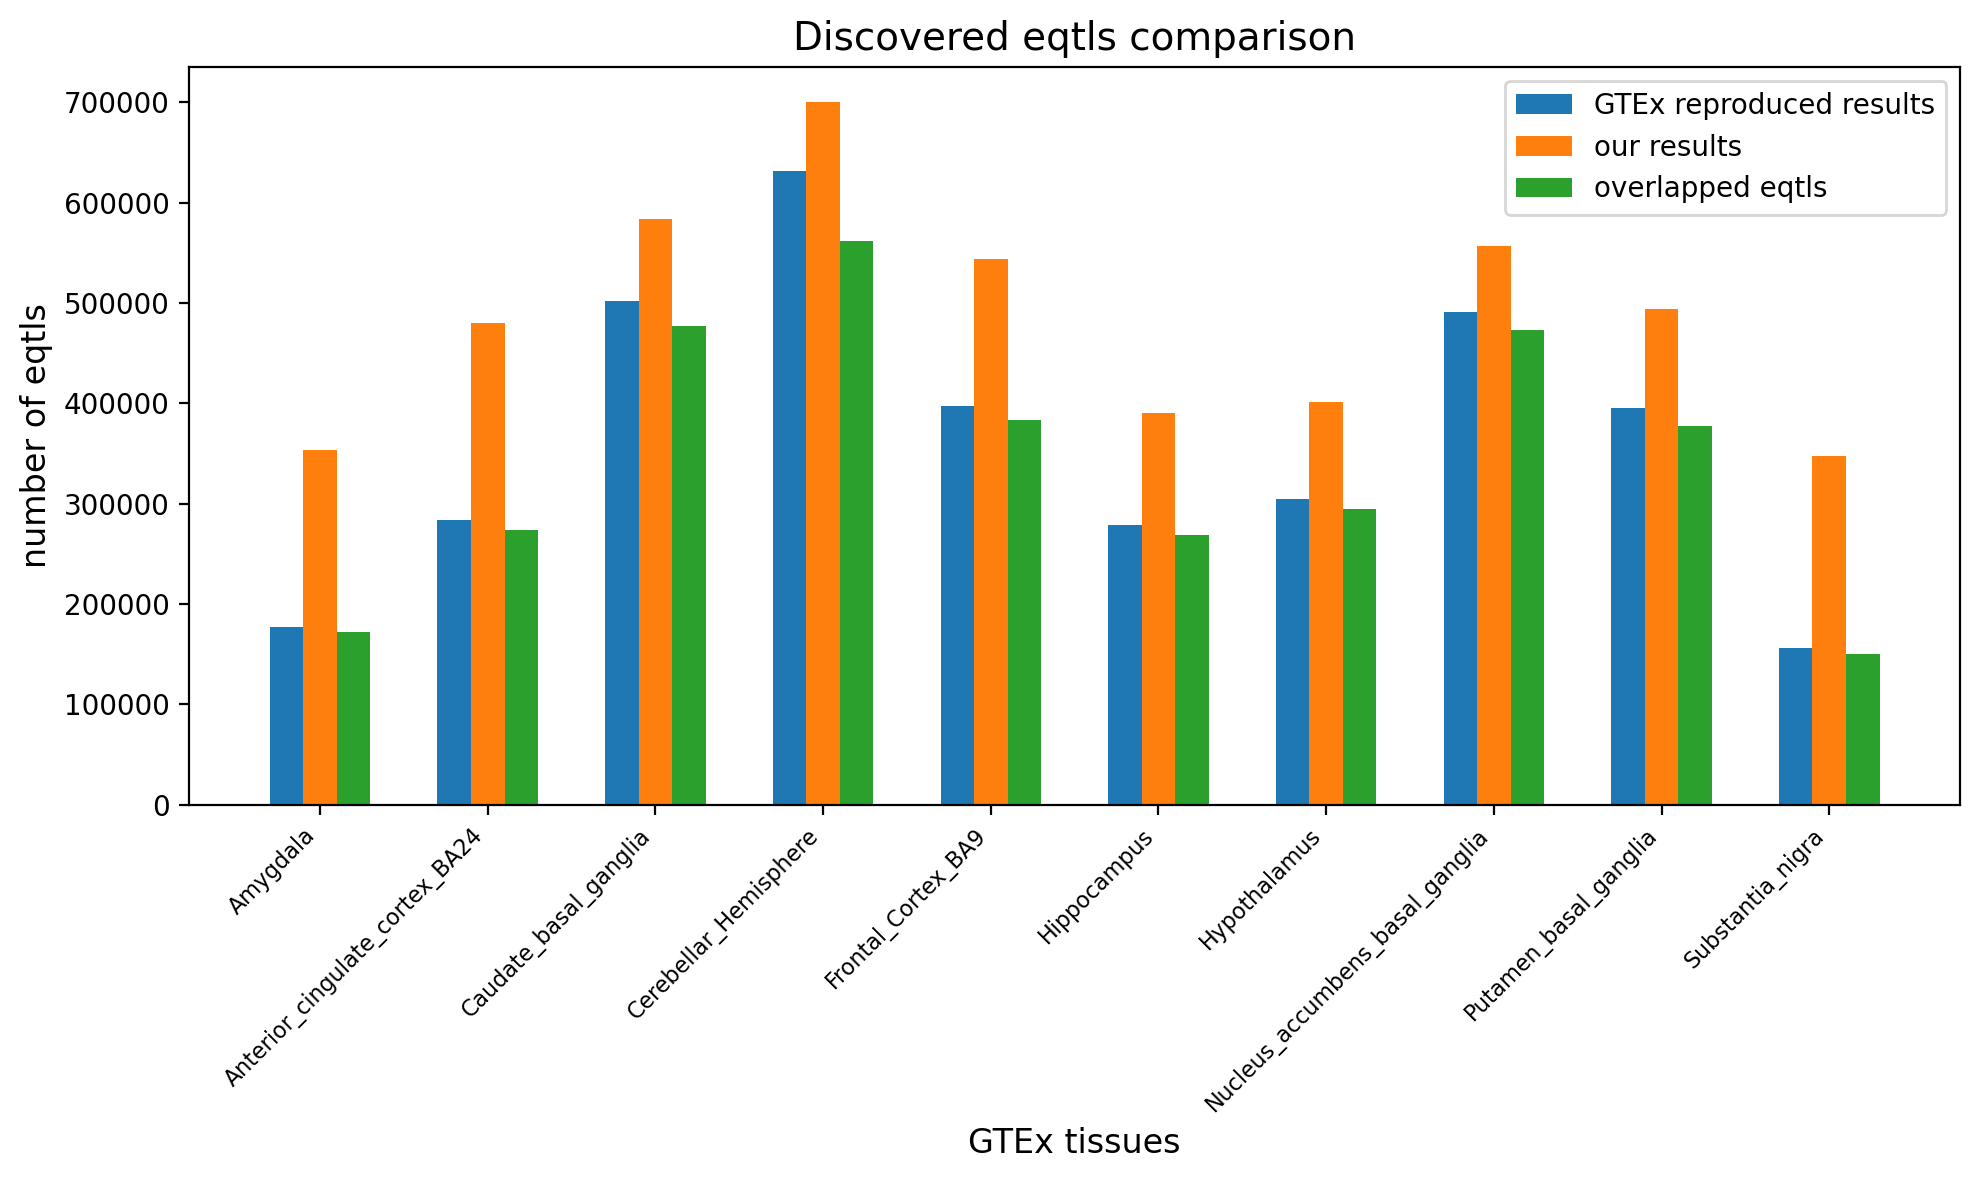

In [5]:
# barplot for the numbers of eqtls
names = region_pick
overlapped_eqtl = df['#intersected eqtl']
gtex_eqtl = df['#eqtl in GTEx']
our_eqtl = df['#eqtl']
# Number of bars per group
num_bars = len(overlapped_eqtl)
# Create an array with the positions for each name on the x-axis
x = np.arange(num_bars)

# Define the width of the bars
plt.figure(figsize=(10, 6), dpi=300)
bar_width = 0.2

# Plot each list with an offset to separate the bars for each group
plt.bar(x - bar_width, gtex_eqtl, width=bar_width, label='GTEx reproduced results')
plt.bar(x, our_eqtl, width=bar_width, label='our results')
plt.bar(x + bar_width, overlapped_eqtl, width=bar_width, label='overlapped eqtls')
# Add labels and title
plt.xlabel('GTEx tissues', fontsize=12)
plt.ylabel('number of eqtls', fontsize=12)
plt.title('Discovered eqtls comparison', fontsize=14)
plt.xticks(x, names, rotation=45, ha='right', fontsize=8)
# Add legend
plt.legend()
# Display the plot
plt.tight_layout()
plt.show()

### 10 GTEx regions eqtl hotmap

In [ ]:
mat_dict = {}
for region in region_pick:
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'
    filename = 'Brain_'+region+'.v8.signif_variant_gene_pairs.txt.gz'
    mat_dict[region] = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')

data = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        region1 = region_pick[i]
        region2 = region_pick[j]
        mat1 = mat_dict[region1]
        mat2 = mat_dict[region2]
        # overlapped eqtl
        merge_df = pd.merge(mat1, mat2, on=['gene_id', 'variant_id', 'tss_distance'], how='inner')
        jaccard_index = (len(merge_df)/(len(mat1)+len(mat2)-len(merge_df)))
        data[i,j] = f"{jaccard_index:.2f}"

df = pd.DataFrame(data, index=region_pick, columns=region_pick)
df

,Amygdala,Anterior_cingulate_cortex_BA24,Caudate_basal_ganglia,Cerebellar_Hemisphere,Frontal_Cortex_BA9,Hippocampus,Hypothalamus,Nucleus_accumbens_basal_ganglia,Putamen_basal_ganglia,Substantia_nigra
Amygdala,1.00,0.51,0.48,0.31,0.46,0.53,0.50,0.47,0.51,0.53
Anterior_cingulate_cortex_BA24,0.51,1.00,0.48,0.34,0.55,0.46,0.47,0.48,0.47,0.48
Caudate_basal_ganglia,0.48,0.48,1.00,0.32,0.45,0.44,0.44,0.53,0.55,0.48
Cerebellar_Hemisphere,0.31,0.34,0.32,1.00,0.34,0.30,0.32,0.32,0.31,0.31
Frontal_Cortex_BA9,0.46,0.55,0.45,0.34,1.00,0.42,0.44,0.46,0.44,0.43
Hippocampus,0.53,0.46,0.44,0.30,0.42,1.00,0.50,0.43,0.47,0.53
Hypothalamus,0.50,0.47,0.44,0.32,0.44,0.50,1.00,0.45,0.46,0.53
Nucleus_accumbens_basal_ganglia,0.47,0.48,0.53,0.32,0.46,0.43,0.45,1.00,0.51,0.46
Putamen_basal_ganglia,0.51,0.47,0.55,0.31,0.44,0.47,0.46,0.51,1.00,0.53
Substantia_nigra,0.53,0.48,0.48,0.31,0.43,0.53,0.53,0.46,0.53,1.00


In [28]:
mat_dict = {}
for region in region_pick:
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/GTEx_Analysis_v8_eQTL/'
    filename = 'Brain_'+region+'.v8.signif_variant_gene_pairs.txt.gz'
    mat_dict[region] = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')

data = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        region1 = region_pick[i]
        region2 = region_pick[j]
        mat1 = mat_dict[region1]
        mat2 = mat_dict[region2]
        # overlapped eqtl
        merge_df = pd.merge(mat1, mat2, on=['gene_id', 'variant_id', 'tss_distance'], how='inner')
        jaccard_index = (len(merge_df)/(len(mat1)+len(mat2)-len(merge_df)))
        data[i,j] = f"{jaccard_index:.2f}"

df = pd.DataFrame(data, index=region_pick, columns=region_pick)
df

,Amygdala,Anterior_cingulate_cortex_BA24,Caudate_basal_ganglia,Cerebellar_Hemisphere,Frontal_Cortex_BA9,Hippocampus,Hypothalamus,Nucleus_accumbens_basal_ganglia,Putamen_basal_ganglia,Substantia_nigra
Amygdala,1.00,0.43,0.31,0.19,0.33,0.42,0.40,0.30,0.37,0.42
Anterior_cingulate_cortex_BA24,0.43,1.00,0.38,0.25,0.45,0.43,0.43,0.38,0.41,0.33
Caudate_basal_ganglia,0.31,0.38,1.00,0.28,0.40,0.39,0.39,0.49,0.49,0.25
Cerebellar_Hemisphere,0.19,0.25,0.28,1.00,0.28,0.24,0.26,0.28,0.26,0.16
Frontal_Cortex_BA9,0.33,0.45,0.40,0.28,1.00,0.38,0.41,0.41,0.40,0.25
Hippocampus,0.42,0.43,0.39,0.24,0.38,1.00,0.44,0.37,0.42,0.37
Hypothalamus,0.40,0.43,0.39,0.26,0.41,0.44,1.00,0.39,0.41,0.35
Nucleus_accumbens_basal_ganglia,0.30,0.38,0.49,0.28,0.41,0.37,0.39,1.00,0.46,0.24
Putamen_basal_ganglia,0.37,0.41,0.49,0.26,0.40,0.42,0.41,0.46,1.00,0.31
Substantia_nigra,0.42,0.33,0.25,0.16,0.25,0.37,0.35,0.24,0.31,1.00


### chuck file from permutation test

In [11]:
match_file = '/project/pi_rachel_melamed_uml_edu/adni/data/ensg2gene_name.txt'
ensg2gene = pd.read_csv(match_file, sep='\t')
ensg2gene

,Unnamed: 0,gene_name
0,ENSG00000223972.5,DDX11L1
1,ENSG00000227232.5,WASH7P
2,ENSG00000278267.1,MIR6859-1
3,ENSG00000243485.5,MIR1302-2HG
4,ENSG00000237613.2,FAM138A
...,...,...
56195,ENSG00000198695.2,MT-ND6
56196,ENSG00000210194.1,MT-TE
56197,ENSG00000198727.2,MT-CYB
56198,ENSG00000210195.2,MT-TT


In [12]:
ensg2gene['gene_name'][ensg2gene['Unnamed: 0'].tolist().index('ENSG00000110002.15')]

'VWA5A'

### check output

In [13]:
# read the GTEx significant variant gene pairs
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/Test_GTEx_fastQTL_results/'
# filename = 'Brain_Amygdala.v8.genes.WGS.txt.gz'
filename = 'Brain_Amygdala.v8.genes.txt.gz'
our_egene_df = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')

data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/GTEx_Analysis_v8_eQTL/'
filename = 'Brain_Amygdala.v8.egenes.txt.gz'
GTEx_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')

In [14]:
our_egene_df

,gene_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,tss_distance,ma_samples,ma_count,maf,ref_factor,pval_nominal,slope,slope_se,pval_perm,pval_beta,qval,pval_nominal_threshold
0,ENSG00000227232.5,6127,1.032200,2706.73,101.735,7.218180e-05,chr1_277677_G_T_b38,248124,123,125,0.484496,1,5.992020e-05,1.126420,0.269200,0.165509,1.658010e-01,1.796600e-01,0.000008
1,ENSG00000240361.1,6403,0.999606,2983.50,104.376,1.869970e-04,chr1_814303_C_T_b38,751355,13,20,0.169492,1,1.920880e-04,-0.569345,0.147223,0.425234,4.278170e-01,2.825720e-01,0.000007
2,ENSG00000186092.4,6454,1.008110,3045.08,104.427,1.332170e-04,chr1_739041_A_T_b38,669950,116,116,0.449612,1,1.375200e-04,-1.024100,0.258622,0.333001,3.296300e-01,2.512980e-01,0.000007
3,ENSG00000268903.1,6975,1.004540,3675.74,105.655,1.660910e-05,chr1_270925_T_C_b38,135030,3,3,0.011628,1,1.935870e-05,-1.748490,0.390446,0.058094,5.836150e-02,1.014930e-01,0.000005
4,ENSG00000269981.1,6987,1.059390,3234.16,103.015,4.074000e-04,chr1_943526_CTTT_C_b38,805561,60,90,0.348837,1,3.820420e-04,-0.320485,0.087279,0.706422,7.107790e-01,3.613190e-01,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24064,ENSG00000224533.4,5285,1.034560,1678.76,101.735,1.041900e-04,chrX_154751297_TG_T_b38,-715243,10,12,0.050847,1,8.716800e-05,0.954406,0.233694,0.147076,1.486220e-01,1.699590e-01,0.000014
24065,ENSG00000185973.10,4661,0.993111,1830.35,105.452,2.519550e-04,chrX_156000131_G_A_b38,330187,76,97,0.378906,1,2.781390e-04,0.275525,0.073221,0.379742,3.728440e-01,2.659180e-01,0.000010
24066,ENSG00000168939.11,4387,1.061450,1209.37,98.607,6.278560e-04,chrX_156023266_C_T_b38,255454,100,107,0.442149,1,4.447450e-04,0.508349,0.140122,0.506835,5.032460e-01,3.052790e-01,0.000021
24067,ENSG00000124333.15,4065,1.009590,1512.79,103.452,6.830790e-05,chrX_156009083_TTG_T_b38,127790,48,48,0.186047,1,6.532640e-05,-0.344850,0.082870,0.097690,9.564970e-02,1.349750e-01,0.000014


In [15]:
GTEx_egene.iloc[:,:]

,gene_id,gene_name,gene_chr,gene_start,gene_end,strand,num_var,beta_shape1,beta_shape2,true_df,...,pval_nominal,slope,slope_se,pval_perm,pval_beta,qval,pval_nominal_threshold,log2_aFC,log2_aFC_lower,log2_aFC_upper
0,ENSG00000227232.5,WASH7P,chr1,14410,29553,-,1364,1.03143,259.194,96.1898,...,0.000336,1.290120,0.347865,0.124379,0.126503,0.188288,0.000069,1.408545,0.913796,1.777867
1,ENSG00000240361.1,OR4G11P,chr1,62948,63887,+,1520,1.01614,273.071,97.8250,...,0.000444,-0.795099,0.219118,0.158537,0.158928,0.211104,0.000061,-5.329756,-6.643856,-1.446458
2,ENSG00000186092.4,OR4F5,chr1,69091,70008,+,1541,1.01328,353.602,102.4770,...,0.000996,-0.806126,0.237949,0.311450,0.312689,0.292072,0.000047,-3.997949,-6.643856,-0.476544
3,ENSG00000268903.1,RP11-34P13.15,chr1,135141,135895,-,1863,1.00834,350.995,98.0687,...,0.000996,-1.058880,0.312560,0.386188,0.383032,0.320121,0.000046,-6.643856,-6.643856,-6.643856
4,ENSG00000269981.1,RP11-34P13.16,chr1,137682,137965,-,1868,1.04705,305.737,94.7477,...,0.000392,0.696341,0.190018,0.178463,0.178976,0.224313,0.000063,1.752805,0.884857,2.482299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24064,ENSG00000224533.4,TMLHE-AS1,chrX,155466540,155611616,+,2569,1.02840,187.711,93.0109,...,0.000272,1.515560,0.402048,0.092991,0.095153,0.163199,0.000094,2.591596,2.114265,NaN
24065,ENSG00000185973.10,TMLHE,chrX,155490115,155669944,-,2301,1.07917,180.959,91.0203,...,0.001258,0.260813,0.078651,0.339207,0.333848,0.299951,0.000121,0.214813,0.097016,0.362581
24066,ENSG00000168939.11,SPRY3,chrX,155767812,155782459,+,2189,1.01800,212.070,96.9617,...,0.006676,0.355419,0.128397,0.836257,0.843037,0.460152,0.000079,0.133095,-0.056687,0.304971
24067,ENSG00000124333.15,VAMP7,chrX,155881293,155943769,+,2035,1.04529,191.517,94.0469,...,0.000928,-0.532340,0.156145,0.251951,0.250428,0.262971,0.000099,-0.228976,-0.304219,-0.055361


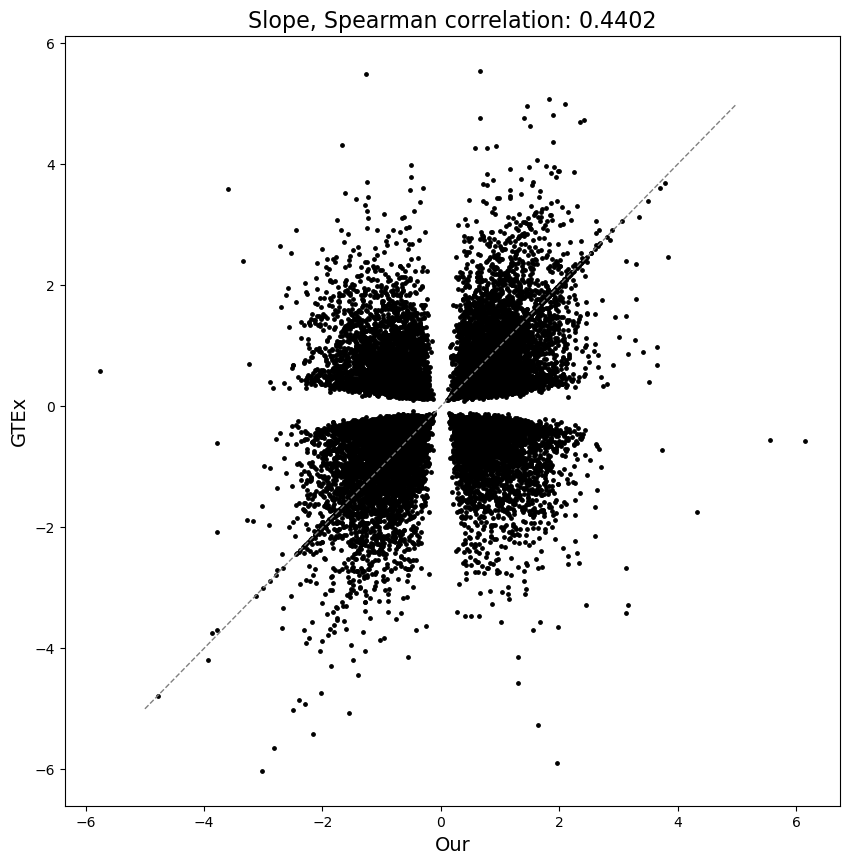

In [16]:
our_slope = our_egene_df['slope']
gtex_slope = GTEx_egene['slope']
lim_range = 5

corr, p = spearmanr(our_slope, gtex_slope)

plt.figure(figsize=(10, 10))
plt.scatter(our_slope, gtex_slope, color='black', marker='o', s=6)
plt.plot([-lim_range, lim_range], [-lim_range, lim_range], linestyle='--', color='grey', linewidth=1)

plt.title(f'Slope, Spearman correlation: {corr:.4f}', fontsize=16)
plt.xlabel('Our', fontsize=14)
plt.ylabel('GTEx', fontsize=14)
# plt.xlim(0, lim_range)
# plt.ylim(0, lim_range)
plt.grid(False)

plt.show()

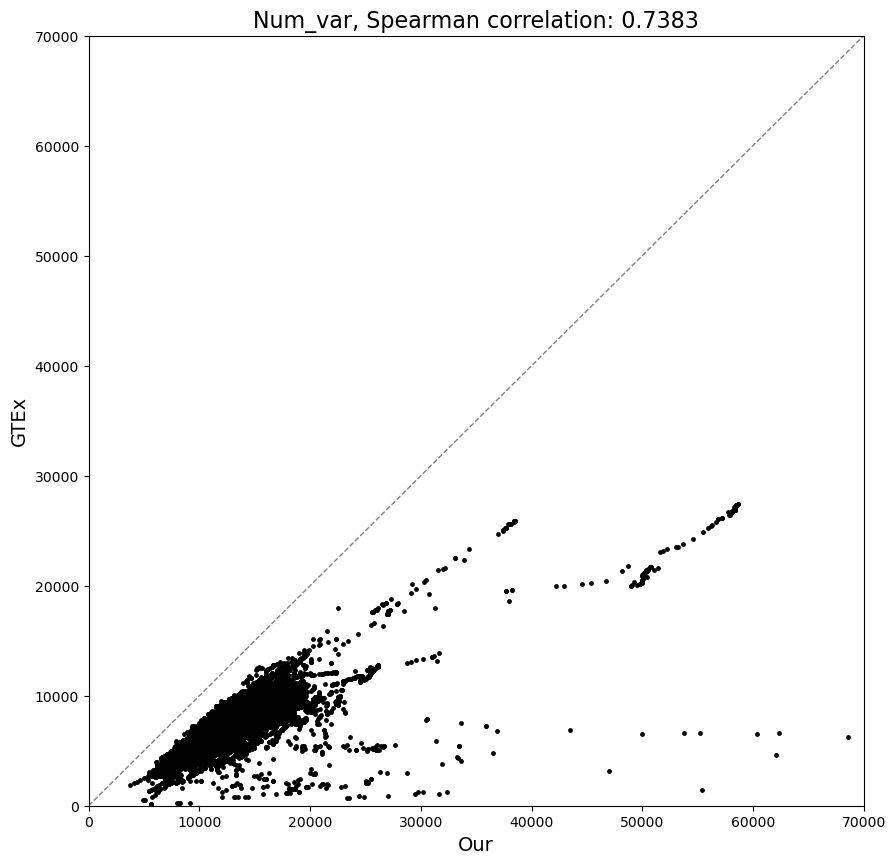

In [17]:
our_num_var = our_egene_df['num_var']
gtex_num_var = GTEx_egene['num_var']
lim_range = 70000

corr, p = spearmanr(our_num_var, gtex_num_var)

plt.figure(figsize=(10, 10))
plt.scatter(our_num_var, gtex_num_var, color='black', marker='o', s=6)
plt.plot([0, lim_range], [0, lim_range], linestyle='--', color='grey', linewidth=1)

plt.title(f'Num_var, Spearman correlation: {corr:.4f}', fontsize=16)
plt.xlabel('Our', fontsize=14)
plt.ylabel('GTEx', fontsize=14)
plt.xlim(0, lim_range)
plt.ylim(0, lim_range)
plt.grid(False)

plt.show()

In [18]:
# read the GTEx allpairs
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/Test_GTEx_fastQTL_results/'
filename = 'Brain_Amygdala.v8.genes.WGS.txt.gz'
our_egene_df = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')

data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/GTEx_Analysis_v8_eQTL/'
filename = 'Brain_Amygdala.v8.egenes.txt.gz'
GTEx_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')

## slope and pval comparison on all GTEx significant gene-variant pairs (our results v.s. original results) (Amygdala)

In [ ]:
region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
               'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
               'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']

picked_region = region_pick[0]

data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/Test_GTEx_fastQTL_results/'
filename = f'Brain_{picked_region}.v8.genes.txt.gz'
gtex_gene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
max(gtex_gene['pval_nominal_threshold'])<0.00015

# module load miniconda/22.11.1-1
# conda activate fastqtl_env
# cd /project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/Test_GTEx_fastQTL_results/
# zcat Brain_Amygdala.v8.allpairs.txt.gz | awk '{ if ($7 < 0.0001) print }' > Brain_Amygdala.0.0001.variant.txt
# region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
#                'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
#                'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']

# find significant ones in cmd
# module load miniconda/22.11.1-1
# conda activate fastqtl_env
# cd /project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/
# zcat Amygdala.allpairs.txt.gz | awk '{ if ($7 < 0.1) print }' > Amygdala.0.1.variant.txt
# zcat Amygdala.allpairs.txt.gz | awk '{ if ($7 < 0.01) print }' > Amygdala.0.01.variant.txt
# zcat Amygdala.allpairs.txt.gz | awk '{ if ($7 < 0.001) print }' > Amygdala.0.001.variant.txt
# zcat Amygdala.allpairs.txt.gz | awk '{ if ($7 < 0.0001) print }' > Amygdala.0.0001.variant.txt

In [ ]:
# our gene.txt
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'
filename = f'{picked_region}.genes.txt.gz'
our_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
# raed GTEx egene.txt
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/GTEx_Analysis_v8_eQTL/'
filename = f'Brain_{picked_region}.v8.egenes.txt.gz'
GTEx_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
# find overlapeed genes
overlapped_gene = list(set(our_egene['gene_id']) & set(GTEx_egene['gene_id']))

# # our variants with pval_nomial<0.1
# data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'
# filename = f'{picked_region}.0.1.variant.txt'
# column_names = ['gene_id', 'variant_id', 'tss_distance', 'ma_samples', 'ma_count', 'maf', 'pval_nominal', 'slope', 'slope_se']
# our_var = pd.read_csv(data_dir+filename, delimiter='\t', names=column_names)
# # gtex variant with pval_nomial<0.0001
# data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/Test_GTEx_fastQTL_results/'
# filename = f'Brain_{picked_region}.0.0001.variant.txt'
# column_names = ['gene_id', 'variant_id', 'tss_distance', 'ma_samples', 'ma_count', 'maf', 'pval_nominal', 'slope', 'slope_se']
# gtex_var = pd.read_csv(data_dir+filename, delimiter='\t', names=column_names)

# only look at those variants on overlapped genes
gtex_var_sub = gtex_var.loc[gtex_var['gene_id'].isin(overlapped_gene)].reset_index(drop=True)
our_var_sub = our_var.loc[our_var['gene_id'].isin(overlapped_gene)].reset_index(drop=True)

# build the gene-variants pairs
col_name = ['gene_id', 'pval_nominal_threshold', 'min_pval_nominal', 'pval_beta']
GTEx_egene_sub = GTEx_egene[['gene_id', 'pval_nominal_threshold', 'pval_nominal', 'pval_beta']]
GTEx_egene_sub.columns = col_name
our_egene_sub = our_egene[['gene_id', 'pval_nominal_threshold', 'pval_nominal', 'pval_beta']]
our_egene_sub.columns = col_name
gtex_gene_var = gtex_var_sub.merge(GTEx_egene_sub, on='gene_id', how='left')
our_gene_var = our_var_sub.merge(our_egene_sub, on='gene_id', how='left')

gtex_eqtl = gtex_gene_var.loc[gtex_gene_var['pval_nominal']<gtex_gene_var['pval_nominal_threshold']].reset_index(drop=True)
merge_df = pd.merge(gtex_eqtl, our_gene_var, on=['gene_id', 'variant_id', 'tss_distance'], how='inner')
# spearman correlation between slope
corr, p = spearmanr(merge_df['slope_x'], merge_df['slope_y'])

In [ ]:
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'

# filename = f'{picked_region}.0.01.variant.txt'
# column_names = ['gene_id', 'variant_id', 'tss_distance', 'ma_samples', 'ma_count', 'maf', 'pval_nominal', 'slope', 'slope_se']
# our_var001 = pd.read_csv(data_dir+filename, delimiter='\t', names=column_names)
# our_var_sub001 = our_var001.loc[our_var001['gene_id'].isin(overlapped_gene)].reset_index(drop=True)
# our_gene_var001 = our_var_sub001.merge(our_egene_sub, on='gene_id', how='left')
# merge_df001 = pd.merge(gtex_eqtl, our_gene_var001, on=['gene_id', 'variant_id', 'tss_distance'], how='inner')

# filename = f'{picked_region}.0.001.variant.txt'
# column_names = ['gene_id', 'variant_id', 'tss_distance', 'ma_samples', 'ma_count', 'maf', 'pval_nominal', 'slope', 'slope_se']
# our_var0001 = pd.read_csv(data_dir+filename, delimiter='\t', names=column_names)
# our_var_sub0001 = our_var0001.loc[our_var0001['gene_id'].isin(overlapped_gene)].reset_index(drop=True)
# our_gene_var0001 = our_var_sub0001.merge(our_egene_sub, on='gene_id', how='left')
# merge_df0001 = pd.merge(gtex_eqtl, our_gene_var0001, on=['gene_id', 'variant_id', 'tss_distance'], how='inner')

# filename = f'{picked_region}.0.0001.variant.txt'
# column_names = ['gene_id', 'variant_id', 'tss_distance', 'ma_samples', 'ma_count', 'maf', 'pval_nominal', 'slope', 'slope_se']
# our_var00001 = pd.read_csv(data_dir+filename, delimiter='\t', names=column_names)
# our_var_sub00001 = our_var00001.loc[our_var00001['gene_id'].isin(overlapped_gene)].reset_index(drop=True)
# our_gene_var00001 = our_var_sub00001.merge(our_egene_sub, on='gene_id', how='left')
# merge_df00001 = pd.merge(gtex_eqtl, our_gene_var00001, on=['gene_id', 'variant_id', 'tss_distance'], how='inner')

# overlapped eqtl
our_eqtl = our_gene_var.loc[our_gene_var['pval_nominal']<our_gene_var['pval_nominal_threshold']].reset_index(drop=True)
merge_eqtl = pd.merge(gtex_eqtl, our_eqtl, on=['gene_id', 'variant_id', 'tss_distance'], how='inner')

# read the GTEx significant variant gene pairs
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/GTEx_Analysis_v8_eQTL/'
filename = f'Brain_{picked_region}.v8.signif_variant_gene_pairs.txt.gz'
gtex_original_eqtl = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
gtex_original_eqtl_sub = gtex_original_eqtl.loc[gtex_original_eqtl['gene_id'].isin(overlapped_gene)].reset_index(drop=True)

In [ ]:
merge_eqtl

In [ ]:
# data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'

# filename = f'{picked_region}.0.0001.variant.txt'
# column_names = ['gene_id', 'variant_id', 'tss_distance', 'ma_samples', 'ma_count', 'maf', 'pval_nominal', 'slope', 'slope_se']
# our_var00001 = pd.read_csv(data_dir+filename, delimiter='\t', names=column_names)

# our_var00001

In [ ]:
# print('Running fastqtl pipeline on GTEx original files to reproduce GTEx results.')
# print(f'Below we compare GTEx reproduced outputs with our results from using using prediction from GO model:')
# print(f'  - There are {len(GTEx_egene)} genes in GTEx and {len(our_egene)} in our results')
# print(f'    - {len(overlapped_gene)} overlapped genes, and on these genes:')
# print(f'      - There are {len(gtex_eqtl)} significant gene-variant pairs in GTEx reproduced results (pval nomimal < pval nominal threshold)')
# print(f'        - {len(merge_df)} of them have a prediction < 0.1 in our results, missing {len(gtex_eqtl)-len(merge_df)}')
# print(f'        - {len(merge_df001)} of them have a prediction < 0.01 in our results, missing {len(gtex_eqtl)-len(merge_df001)}')
# print(f'        - {len(merge_df0001)} of them have a prediction < 0.001 in our results, missing {len(gtex_eqtl)-len(merge_df0001)}')
# print(f'        - {len(merge_df00001)} of them have a prediction < 0.0001 in our results, missing {len(gtex_eqtl)-len(merge_df00001)}')
# print(f'        - {len(merge_eqtl)} overlapped eqtls, missing {len(gtex_eqtl)-len(merge_eqtl)}')
# print(f'      - There are {len(our_eqtl)} significant gene-variant pairs in our results')
# print(f'      - Also, for comparison, there are {len(gtex_original_eqtl_sub)} eqtl in GTEx original results on {len(overlapped_gene)} overlapped genes')

In [ ]:
# gtex_pval = merge_df['pval_nominal_x']
# our_pval = merge_df['pval_nominal_y']
# lim_range = 1

# corr, p = spearmanr(our_pval, gtex_pval)

# plt.figure(figsize=(6, 6))
# plt.scatter(our_pval, gtex_pval, color='black', marker='o', s=6)
# plt.plot([-lim_range, lim_range], [-lim_range, lim_range], linestyle='--', color='grey', linewidth=1)

# plt.title(f'pval nominal, Spearman correlation: {corr:.4f}', fontsize=10)
# plt.xlabel('Our analysis', fontsize=10)
# plt.ylabel('GTEx portal', fontsize=10)
# plt.xlim(1e-70, 1e-0)
# plt.ylim(1e-70, 1e-0)
# plt.grid(False)
# plt.xscale('log')
# plt.yscale('log')

# plt.show()

In [ ]:
# gtex_slope = merge_df['slope_x']
# our_slope = merge_df['slope_y']
# lim_range = max([max(abs(our_slope)), max(abs(gtex_slope))])

# corr, p = spearmanr(our_slope, gtex_slope)

# plt.figure(figsize=(6, 6))
# plt.scatter(our_slope, gtex_slope, color='black', marker='o', s=6)
# plt.plot([-lim_range, lim_range], [-lim_range, lim_range], linestyle='--', color='grey', linewidth=1)

# plt.title(f'Slope, Spearman correlation: {corr:.4f}', fontsize=10)
# plt.xlabel('Our analysis', fontsize=10)
# plt.ylabel('GTEx portal', fontsize=10)
# plt.xlim(-lim_range, lim_range)
# plt.ylim(-lim_range, lim_range)
# plt.grid(False)

# plt.show()

In [ ]:
gtex_pval = merge_eqtl['pval_nominal_x']
our_pval = merge_eqtl['pval_nominal_y']
lim_range = 1

corr, p = spearmanr(our_pval, gtex_pval)

plt.figure(figsize=(6, 6), dpi=300)
plt.scatter(our_pval, gtex_pval, color='black', marker='o', s=6)
plt.plot([-lim_range, lim_range], [-lim_range, lim_range], linestyle='--', color='grey', linewidth=1)

plt.title(f'P-values comparison for {picked_region}, Spearman correlation: {corr:.4f}', fontsize=8)
plt.xlabel('Our results', fontsize=8)
plt.ylabel('GTEx results', fontsize=8)
plt.xlim(1e-70, 1e-0)
plt.ylim(1e-70, 1e-0)
plt.grid(False)
plt.xscale('log')
plt.yscale('log')

plt.show()

In [ ]:
gtex_slope = merge_eqtl['slope_x']
our_slope = merge_eqtl['slope_y']
# lim_range = max([max(abs(our_slope)), max(abs(gtex_slope))])
lim_range = 4

corr, p = spearmanr(our_slope, gtex_slope)

plt.figure(figsize=(6, 6), dpi=300)
plt.scatter(our_slope, gtex_slope, color='black', marker='o', s=6)
plt.plot([-lim_range, lim_range], [-lim_range, lim_range], linestyle='--', color='grey', linewidth=1)

plt.title(f'Slope comparison for {picked_region}, Spearman correlation: {corr:.4f}', fontsize=8)
plt.xlabel('Our results', fontsize=8)
plt.ylabel('GTEx results', fontsize=8)
plt.xlim(-lim_range, lim_range)
plt.ylim(-lim_range, lim_range)
plt.grid(False)

plt.show()

### analysis those significant in GTEx but found not significant in our results

In [53]:
x = pd.merge(gtex_eqtl, merge_df, on=['gene_id', 'variant_id', 'tss_distance'], how='left', indicator=True)
outer_eqtl01only = x[x['_merge'] == 'left_only']
outer_eqtl01only = outer_eqtl01only.drop(columns=['_merge']).reset_index(drop=True)

x = pd.merge(merge_df, merge_df001, on=['gene_id', 'variant_id', 'tss_distance'], how='left', indicator=True)
outer_eqtl001only = x[x['_merge'] == 'left_only']
outer_eqtl001only = outer_eqtl001only.drop(columns=['_merge']).reset_index(drop=True)

x = pd.merge(merge_df001, merge_df0001, on=['gene_id', 'variant_id', 'tss_distance'], how='left', indicator=True)
outer_eqtl0001only = x[x['_merge'] == 'left_only']
outer_eqtl0001only = outer_eqtl0001only.drop(columns=['_merge']).reset_index(drop=True)

x = pd.merge(merge_df0001, merge_df00001, on=['gene_id', 'variant_id', 'tss_distance'], how='left', indicator=True)
outer_eqtl00001only = x[x['_merge'] == 'left_only']
outer_eqtl00001only = outer_eqtl00001only.drop(columns=['_merge']).reset_index(drop=True)

x = pd.merge(merge_df00001, merge_eqtl, on=['gene_id', 'variant_id', 'tss_distance'], how='left', indicator=True)
outer_eqtl00003only = x[x['_merge'] == 'left_only']
outer_eqtl00003only = outer_eqtl00003only.drop(columns=['_merge']).reset_index(drop=True)

merge_eqtl = merge_eqtl

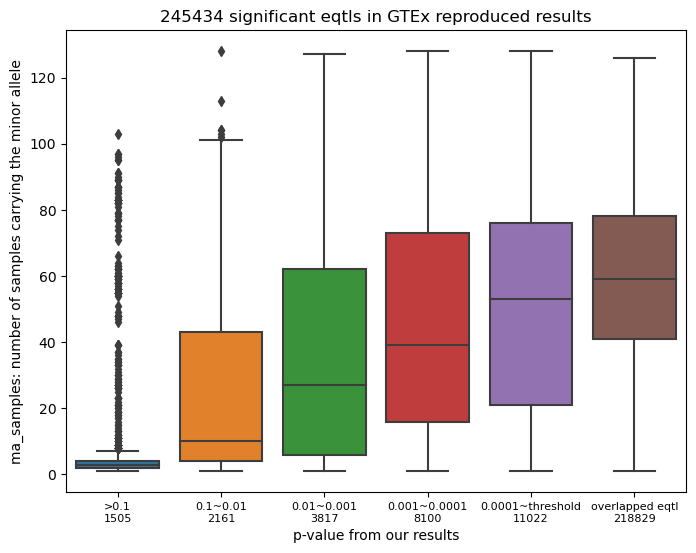

In [80]:
# violin plot to show the number of sample in each interval
list01 = outer_eqtl01only.iloc[:,3].tolist()
list001 = outer_eqtl001only.iloc[:,3].tolist()
list0001 = outer_eqtl0001only.iloc[:,3].tolist()
list00001 = outer_eqtl00001only.iloc[:,3].tolist()
list00003 = outer_eqtl00003only.iloc[:,3].tolist()
list_eqtl = merge_eqtl.iloc[:,3].tolist()

# Combine data into a single DataFrame for easier plotting
import pandas as pd

data = pd.DataFrame({
    'Value': list01 + list001+ list0001+ list00001+ list00003+ list_eqtl,
    'Category': [f'>0.1\n{len(list01)}'] * len(list01) + [f'0.1~0.01\n{len(list001)}'] * len(list001) + 
    [f'0.01~0.001\n{len(list0001)}'] * len(list0001) + [f'0.001~0.0001\n{len(list00001)}'] * len(list00001) + 
    [f'0.0001~threshold\n{len(list00003)}'] * len(list00003) + [f'overlapped eqtl\n{len(list_eqtl)}'] * len(list_eqtl) 
})

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Category', y='Value', data=data)
plt.title(f'{len(gtex_eqtl)} significant eqtls in GTEx reproduced results', fontsize=12)
plt.xlabel('p-value from our results', fontsize=10)
plt.ylabel(f'ma_samples: number of samples carrying the minor allele', fontsize=10)
plt.xticks(fontsize=8)
plt.show()

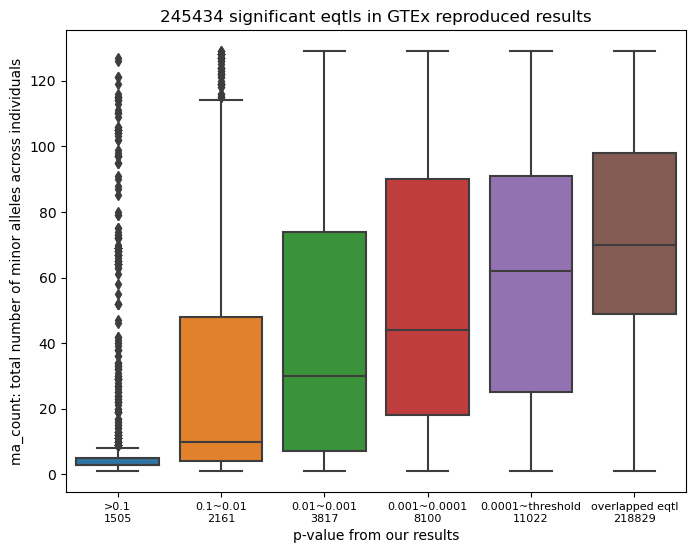

In [81]:
# violin plot to show the number of sample in each interval
list01 = outer_eqtl01only.iloc[:,4].tolist()
list001 = outer_eqtl001only.iloc[:,4].tolist()
list0001 = outer_eqtl0001only.iloc[:,4].tolist()
list00001 = outer_eqtl00001only.iloc[:,4].tolist()
list00003 = outer_eqtl00003only.iloc[:,4].tolist()
list_eqtl = merge_eqtl.iloc[:,4].tolist()

# Combine data into a single DataFrame for easier plotting
import pandas as pd

data = pd.DataFrame({
    'Value': list01 + list001+ list0001+ list00001+ list00003+ list_eqtl,
    'Category': [f'>0.1\n{len(list01)}'] * len(list01) + [f'0.1~0.01\n{len(list001)}'] * len(list001) + 
    [f'0.01~0.001\n{len(list0001)}'] * len(list0001) + [f'0.001~0.0001\n{len(list00001)}'] * len(list00001) + 
    [f'0.0001~threshold\n{len(list00003)}'] * len(list00003) + [f'overlapped eqtl\n{len(list_eqtl)}'] * len(list_eqtl) 
})

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Category', y='Value', data=data)
plt.title(f'{len(gtex_eqtl)} significant eqtls in GTEx reproduced results', fontsize=12)
plt.xlabel('p-value from our results', fontsize=10)
plt.ylabel(f'ma_count: total number of minor alleles across individuals', fontsize=10)
plt.xticks(fontsize=8)
plt.show()

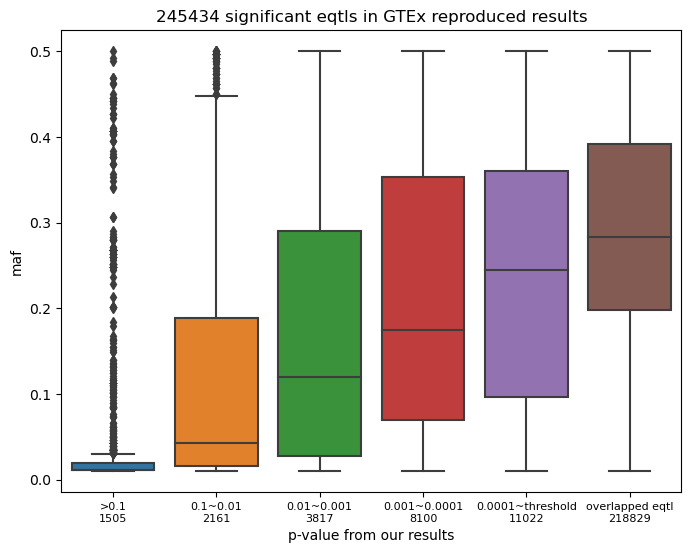

In [85]:
# violin plot to show the number of sample in each interval
list01 = outer_eqtl01only.iloc[:,5].tolist()
list001 = outer_eqtl001only.iloc[:,5].tolist()
list0001 = outer_eqtl0001only.iloc[:,5].tolist()
list00001 = outer_eqtl00001only.iloc[:,5].tolist()
list00003 = outer_eqtl00003only.iloc[:,5].tolist()
list_eqtl = merge_eqtl.iloc[:,5].tolist()

# Combine data into a single DataFrame for easier plotting
import pandas as pd

data = pd.DataFrame({
    'Value': list01 + list001+ list0001+ list00001+ list00003+ list_eqtl,
    'Category': [f'>0.1\n{len(list01)}'] * len(list01) + [f'0.1~0.01\n{len(list001)}'] * len(list001) + 
    [f'0.01~0.001\n{len(list0001)}'] * len(list0001) + [f'0.001~0.0001\n{len(list00001)}'] * len(list00001) + 
    [f'0.0001~threshold\n{len(list00003)}'] * len(list00003) + [f'overlapped eqtl\n{len(list_eqtl)}'] * len(list_eqtl) 
})

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Category', y='Value', data=data)
plt.title(f'{len(gtex_eqtl)} significant eqtls in GTEx reproduced results', fontsize=12)
plt.xlabel('p-value from our results', fontsize=10)
plt.ylabel(f'maf', fontsize=10)
plt.xticks(fontsize=8)
plt.show()

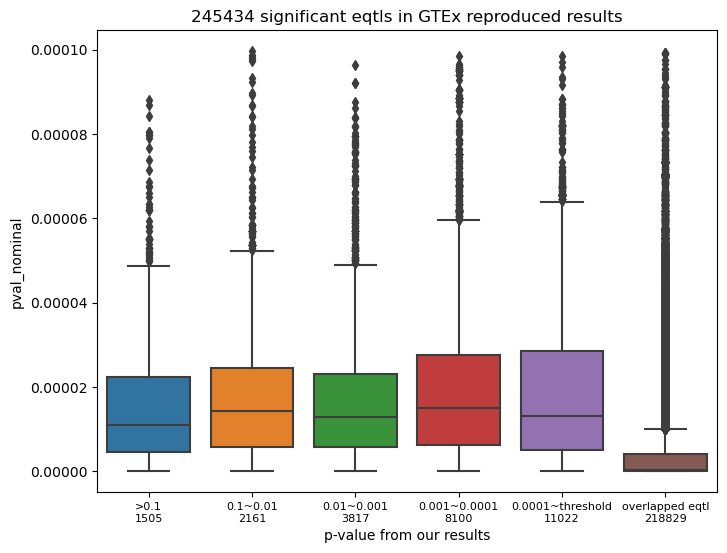

In [84]:
# violin plot to show the number of sample in each interval
list01 = outer_eqtl01only.iloc[:,6].tolist()
list001 = outer_eqtl001only.iloc[:,6].tolist()
list0001 = outer_eqtl0001only.iloc[:,6].tolist()
list00001 = outer_eqtl00001only.iloc[:,6].tolist()
list00003 = outer_eqtl00003only.iloc[:,6].tolist()
list_eqtl = merge_eqtl.iloc[:,6].tolist()

# Combine data into a single DataFrame for easier plotting
import pandas as pd

data = pd.DataFrame({
    'Value': list01 + list001+ list0001+ list00001+ list00003+ list_eqtl,
    'Category': [f'>0.1\n{len(list01)}'] * len(list01) + [f'0.1~0.01\n{len(list001)}'] * len(list001) + 
    [f'0.01~0.001\n{len(list0001)}'] * len(list0001) + [f'0.001~0.0001\n{len(list00001)}'] * len(list00001) + 
    [f'0.0001~threshold\n{len(list00003)}'] * len(list00003) + [f'overlapped eqtl\n{len(list_eqtl)}'] * len(list_eqtl) 
})

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Category', y='Value', data=data)
plt.title(f'{len(gtex_eqtl)} significant eqtls in GTEx reproduced results', fontsize=12)
plt.xlabel('p-value from our results', fontsize=10)
plt.ylabel(f'pval_nominal', fontsize=10)
plt.xticks(fontsize=8)
plt.show()

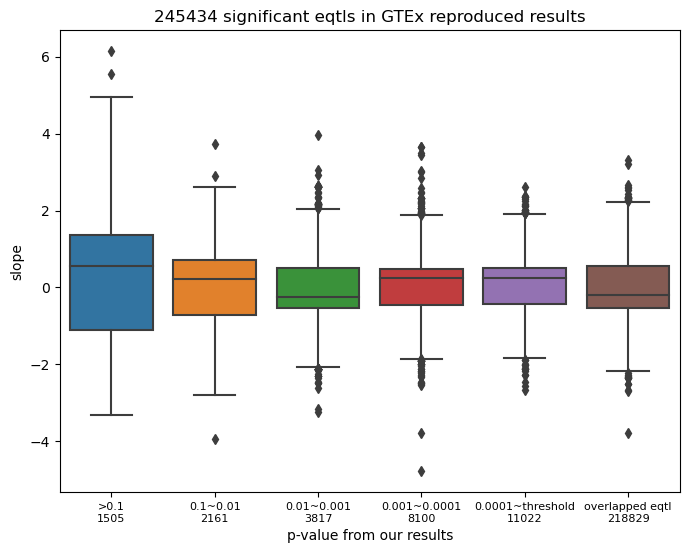

In [86]:
# violin plot to show the number of sample in each interval
list01 = outer_eqtl01only.iloc[:,7].tolist()
list001 = outer_eqtl001only.iloc[:,7].tolist()
list0001 = outer_eqtl0001only.iloc[:,7].tolist()
list00001 = outer_eqtl00001only.iloc[:,7].tolist()
list00003 = outer_eqtl00003only.iloc[:,7].tolist()
list_eqtl = merge_eqtl.iloc[:,7].tolist()

# Combine data into a single DataFrame for easier plotting
import pandas as pd

data = pd.DataFrame({
    'Value': list01 + list001+ list0001+ list00001+ list00003+ list_eqtl,
    'Category': [f'>0.1\n{len(list01)}'] * len(list01) + [f'0.1~0.01\n{len(list001)}'] * len(list001) + 
    [f'0.01~0.001\n{len(list0001)}'] * len(list0001) + [f'0.001~0.0001\n{len(list00001)}'] * len(list00001) + 
    [f'0.0001~threshold\n{len(list00003)}'] * len(list00003) + [f'overlapped eqtl\n{len(list_eqtl)}'] * len(list_eqtl) 
})

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Category', y='Value', data=data)
plt.title(f'{len(gtex_eqtl)} significant eqtls in GTEx reproduced results', fontsize=12)
plt.xlabel('p-value from our results', fontsize=10)
plt.ylabel(f'slope', fontsize=10)
plt.xticks(fontsize=8)
plt.show()

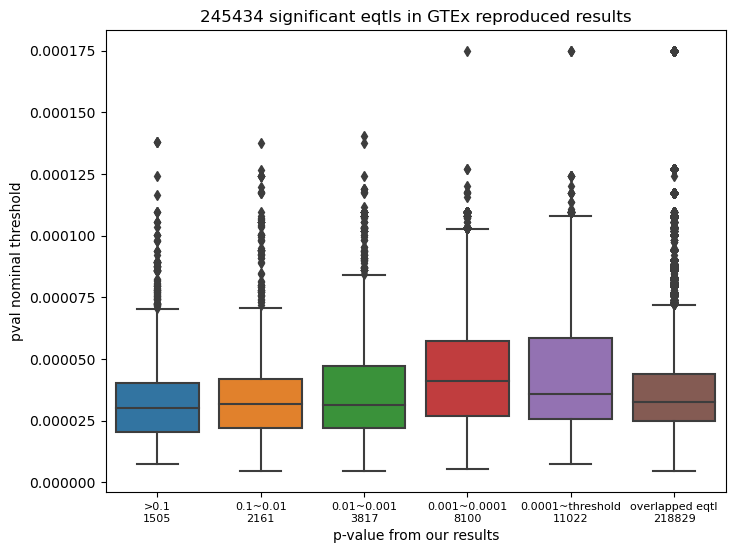

In [87]:
# violin plot to show the number of sample in each interval
list01 = outer_eqtl01only.iloc[:,9].tolist()
list001 = outer_eqtl001only.iloc[:,9].tolist()
list0001 = outer_eqtl0001only.iloc[:,9].tolist()
list00001 = outer_eqtl00001only.iloc[:,9].tolist()
list00003 = outer_eqtl00003only.iloc[:,9].tolist()
list_eqtl = merge_eqtl.iloc[:,9].tolist()

# Combine data into a single DataFrame for easier plotting
import pandas as pd

data = pd.DataFrame({
    'Value': list01 + list001+ list0001+ list00001+ list00003+ list_eqtl,
    'Category': [f'>0.1\n{len(list01)}'] * len(list01) + [f'0.1~0.01\n{len(list001)}'] * len(list001) + 
    [f'0.01~0.001\n{len(list0001)}'] * len(list0001) + [f'0.001~0.0001\n{len(list00001)}'] * len(list00001) + 
    [f'0.0001~threshold\n{len(list00003)}'] * len(list00003) + [f'overlapped eqtl\n{len(list_eqtl)}'] * len(list_eqtl) 
})

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Category', y='Value', data=data)
plt.title(f'{len(gtex_eqtl)} significant eqtls in GTEx reproduced results', fontsize=12)
plt.xlabel('p-value from our results', fontsize=10)
plt.ylabel(f'pval nominal threshold', fontsize=10)
plt.xticks(fontsize=8)
plt.show()

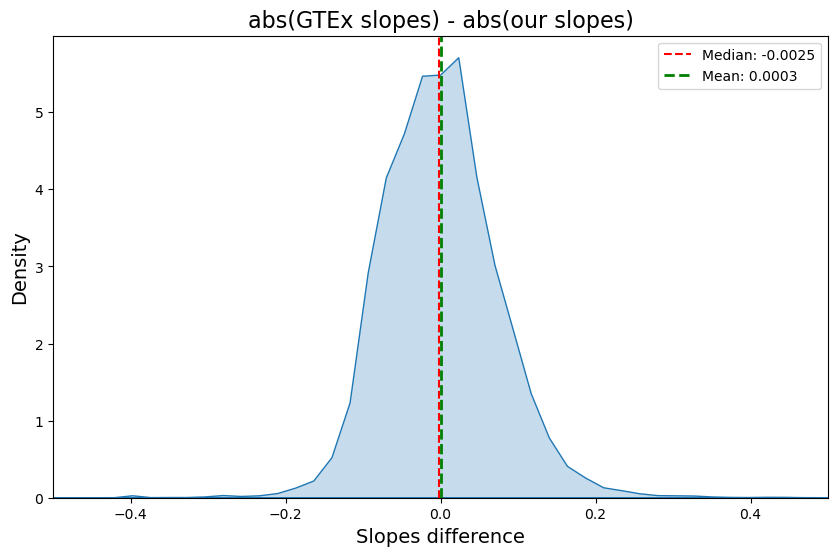

In [30]:
# slope comparison
data = np.array(abs(merge_eqtl['slope_x'])) - np.array(abs(merge_eqtl['slope_y']))
median_value = np.median(data)
mean_value = np.mean(data)
# Create the density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data, fill=True)
plt.axvline(median_value, color='r', linestyle='--', label=f'Median: {median_value:.4f}')
plt.axvline(mean_value, color='g', linestyle='--', label=f'Mean: {mean_value:.4f}', linewidth=2)

plt.title('abs(GTEx slopes) - abs(our slopes)', fontsize=16)
plt.xlabel('Slopes difference', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.xlim(-0.5, 0.5)
plt.show()

## slope and pval comparison on all GTEx significant gene-variant pairs (our results v.s. reproduced results) (Amygdala)

In [2]:
region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
               'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
               'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']

picked_region = region_pick[0]

# our gene.txt
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'
filename = 'Amygdala.genes.txt.gz'
our_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
# raed GTEx egene.txt
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/Test_GTEx_fastQTL_results/'
filename = 'Amygdala.genes.txt.gz'
GTEx_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
# find overlapeed genes
overlapped_gene = list(set(our_egene['gene_id']) & set(GTEx_egene['gene_id']))

# our gene.txt
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'
filename = picked_region+'.sig-gene-variant.csv'
sig_var_gene_pairs = pd.read_csv(data_dir+filename)
sig_var_gene_pairs_sub = sig_var_gene_pairs.loc[sig_var_gene_pairs['gene_id'].isin(overlapped_gene)].reset_index(drop=True)
# read the GTEx significant variant gene pairs
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/Test_GTEx_fastQTL_results/'
filename = picked_region+'.sig-gene-variant.csv'
gtex_sig_var_gene = pd.read_csv(data_dir+filename)
gtex_sig_var_gene_sub = gtex_sig_var_gene.loc[gtex_sig_var_gene['gene_id'].isin(overlapped_gene)].reset_index(drop=True)

# overlapped eqtl genes
overlapped_eqtl_gene = list(set(sig_var_gene_pairs_sub['gene_id']) & set(gtex_sig_var_gene_sub['gene_id']))
our_eqtl_on_common_gene = sig_var_gene_pairs_sub.loc[sig_var_gene_pairs_sub['gene_id'].isin(overlapped_eqtl_gene)].reset_index(drop=True)
gtex_eqtl_on_common_gene = gtex_sig_var_gene_sub.loc[gtex_sig_var_gene_sub['gene_id'].isin(overlapped_eqtl_gene)].reset_index(drop=True)

# overlapped var-gene pairs
merge_df = pd.merge(our_eqtl_on_common_gene, gtex_eqtl_on_common_gene, on=['gene_id', 'variant_id', 'tss_distance'], how='inner')
print(max(merge_df['pval_nominal_threshold_x'])<0.00015)
print(max(merge_df['pval_nominal_threshold_y'])<0.00015)
# spearman correlation between slope
corr, p = spearmanr(merge_df['slope_x'], merge_df['slope_y'])


True
True


In [3]:
merge_df

,gene_id,variant_id,tss_distance,ma_samples_x,ma_count_x,maf_x,pval_nominal_x,slope_x,slope_se_x,pval_nominal_threshold_x,...,pval_beta_x,ma_samples_y,ma_count_y,maf_y,pval_nominal_y,slope_y,slope_se_y,pval_nominal_threshold_y,min_pval_nominal_y,pval_beta_y
0,ENSG00000225880.5,chr1_758351_A_G_b38,-69171,50,54,0.136364,6.633230e-06,0.498381,0.106914,0.000010,...,1.381140e-08,32,35,0.135659,1.198180e-06,0.699531,0.135615,0.000003,1.352440e-09,5.408560e-06
1,ENSG00000225880.5,chr1_758443_G_C_b38,-69079,51,54,0.136364,4.091220e-06,0.522681,0.109490,0.000010,...,1.381140e-08,32,35,0.135659,1.198180e-06,0.699531,0.135615,0.000003,1.352440e-09,5.408560e-06
2,ENSG00000225880.5,chr1_789568_TATGGA_T_b38,-37954,83,91,0.229798,2.705680e-09,-0.615472,0.097561,0.000010,...,1.381140e-08,55,61,0.236434,1.294650e-07,-0.704141,0.124207,0.000003,1.352440e-09,5.408560e-06
3,ENSG00000225880.5,chr1_794299_C_G_b38,-33223,75,83,0.209596,1.324080e-10,-0.656455,0.095418,0.000010,...,1.381140e-08,50,56,0.217054,2.113590e-08,-0.754394,0.124294,0.000003,1.352440e-09,5.408560e-06
4,ENSG00000225880.5,chr1_800909_T_A_b38,-26613,57,59,0.148990,1.013730e-07,0.583205,0.104485,0.000010,...,1.381140e-08,39,41,0.158915,2.761580e-07,0.710636,0.129257,0.000003,1.352440e-09,5.408560e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171862,ENSG00000277203.1,chrX_155739965_G_A_b38,853616,16,16,0.040404,5.845900e-07,-1.080090,0.207350,0.000021,...,6.497640e-17,12,12,0.046512,1.749400e-06,-1.195540,0.235864,0.000007,4.152120e-14,7.275330e-11
171863,ENSG00000277203.1,chrX_155740785_C_T_b38,854436,16,16,0.040404,5.845900e-07,-1.080090,0.207350,0.000021,...,6.497640e-17,12,12,0.046512,1.749400e-06,-1.195540,0.235864,0.000007,4.152120e-14,7.275330e-11
171864,ENSG00000277203.1,chrX_155746397_G_A_b38,860048,154,180,0.454545,4.134980e-11,-0.644131,0.090804,0.000021,...,6.497640e-17,101,114,0.441860,1.210280e-07,-0.673782,0.118536,0.000007,4.152120e-14,7.275330e-11
171865,ENSG00000277203.1,chrX_155747288_G_A_b38,860939,16,16,0.040404,5.845900e-07,-1.080090,0.207350,0.000021,...,6.497640e-17,12,12,0.046512,1.749400e-06,-1.195540,0.235864,0.000007,4.152120e-14,7.275330e-11


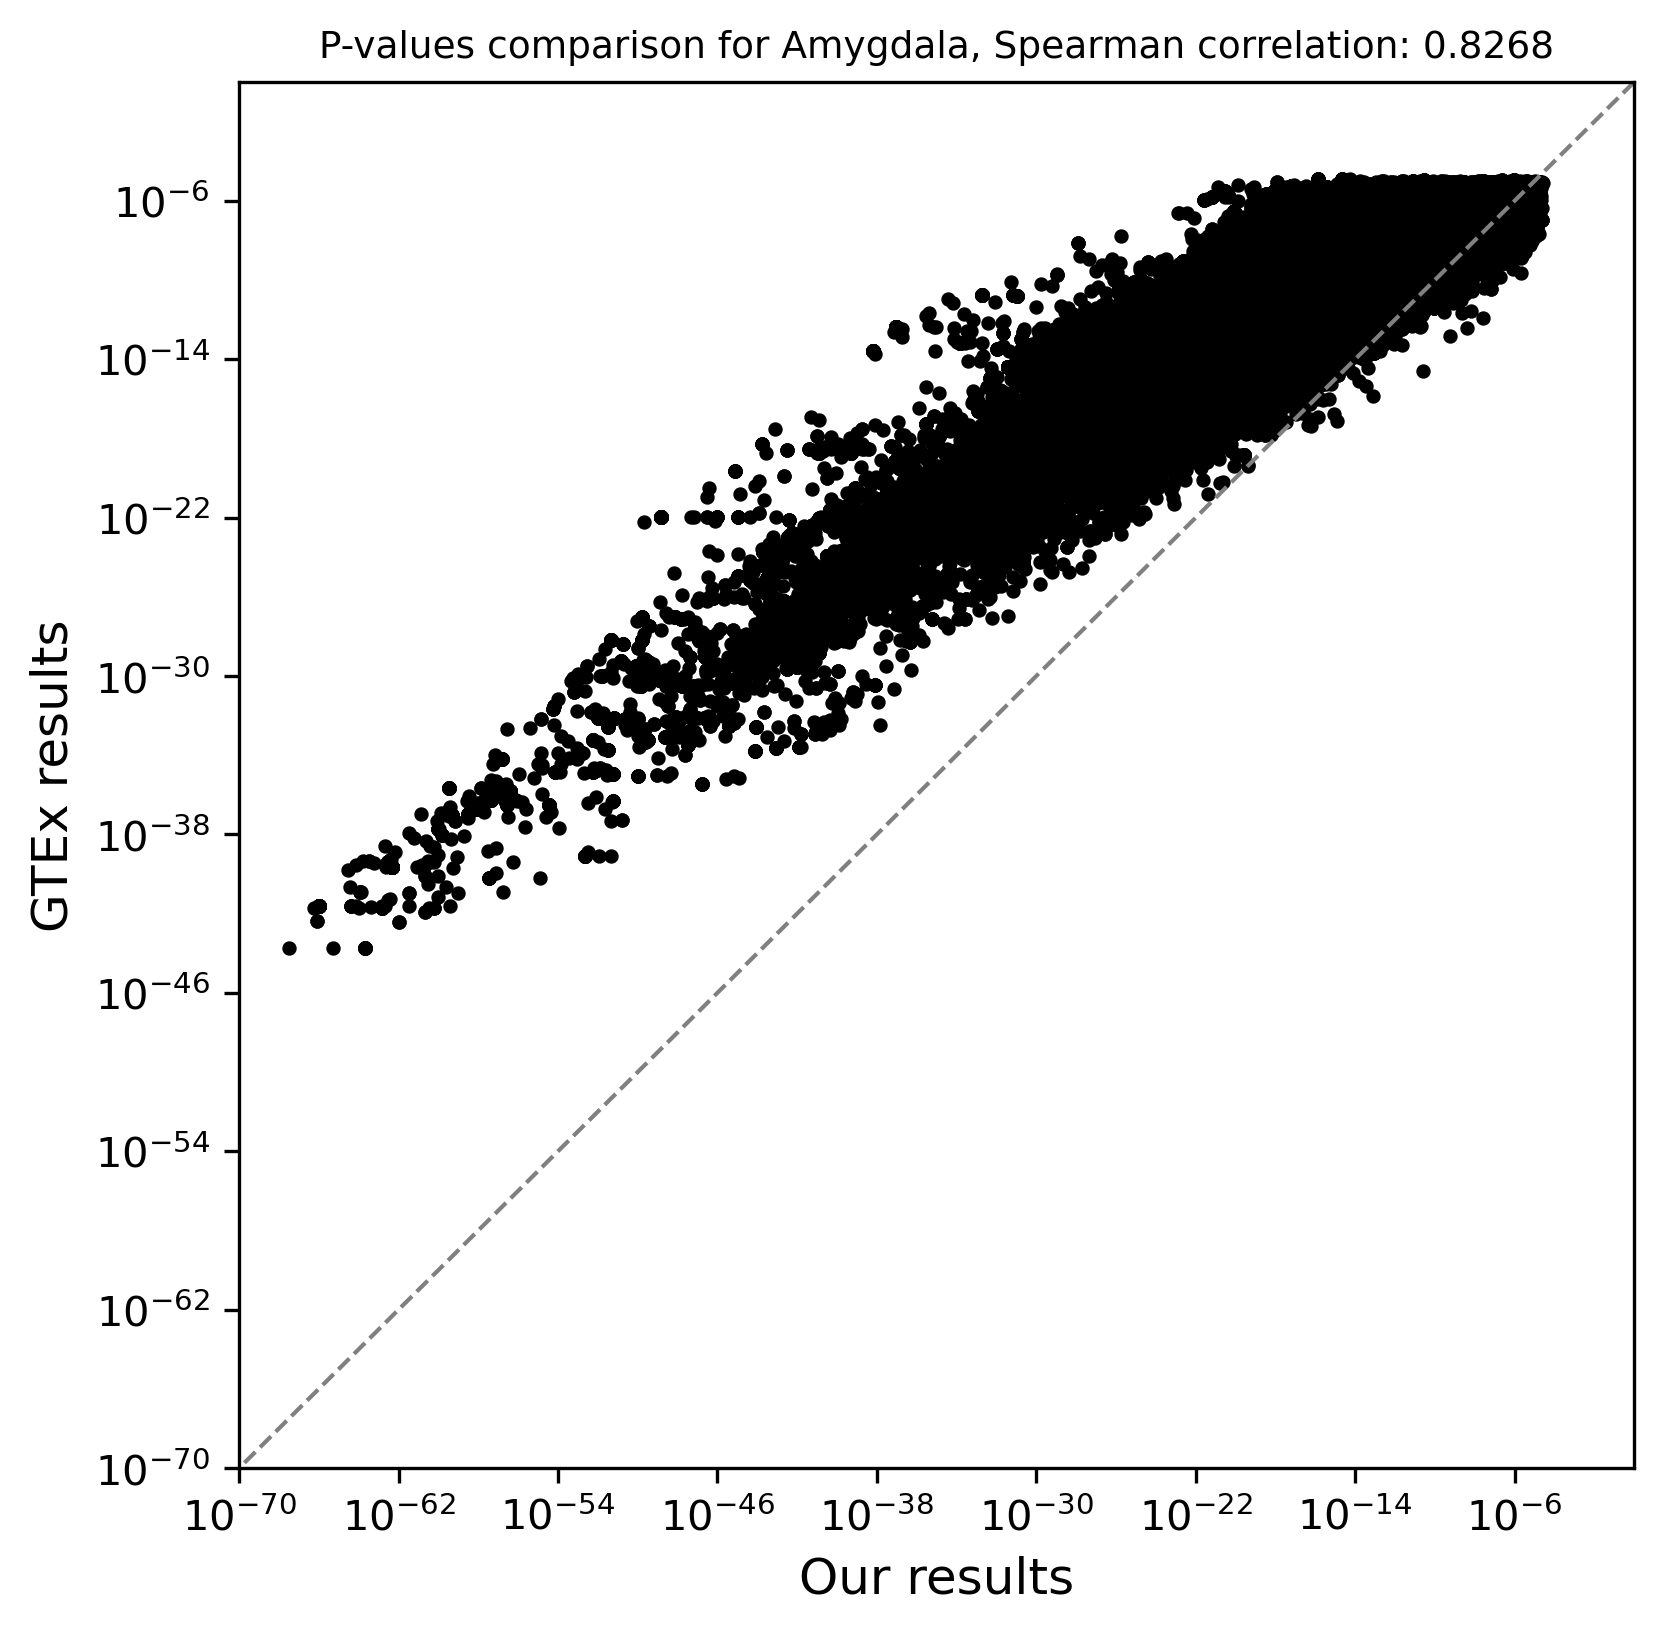

In [4]:
gtex_pval = merge_df['pval_nominal_y']
our_pval = merge_df['pval_nominal_x']
lim_range = 1

corr, p = spearmanr(our_pval, gtex_pval)

plt.figure(figsize=(6, 6), dpi=300)
plt.scatter(our_pval, gtex_pval, color='black', marker='o', s=6)
plt.plot([-lim_range, lim_range], [-lim_range, lim_range], linestyle='--', color='grey', linewidth=1)

plt.title(f'P-values comparison for {picked_region}, Spearman correlation: {corr:.4f}', fontsize=9)
plt.xlabel('Our results', fontsize=12)
plt.ylabel('GTEx results', fontsize=12)
plt.xlim(1e-70, 1e-0)
plt.ylim(1e-70, 1e-0)
plt.grid(False)
plt.xscale('log')
plt.yscale('log')

plt.show()

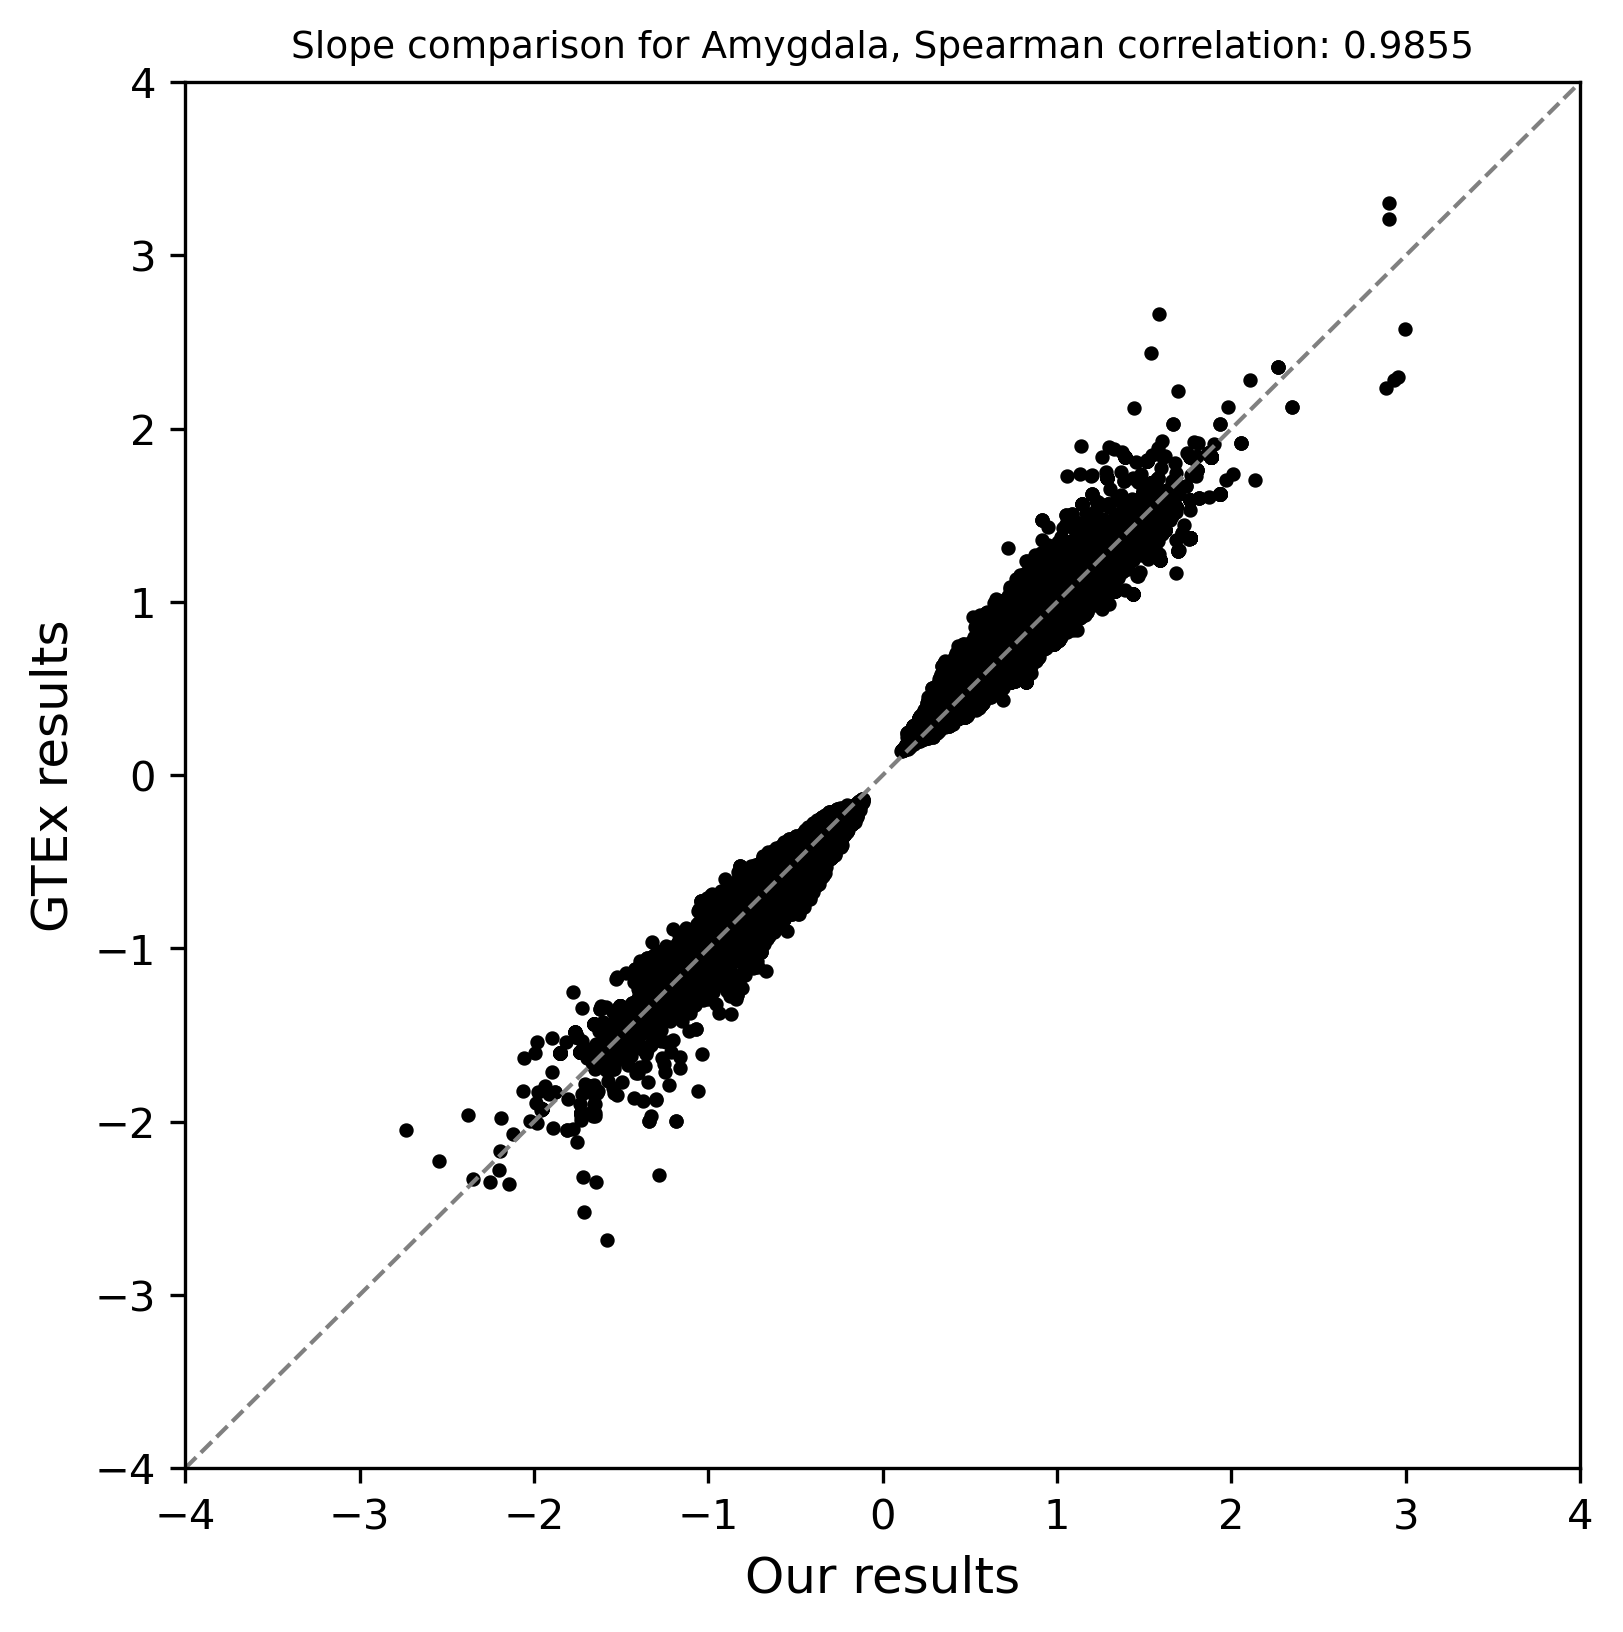

In [5]:
gtex_slope = merge_df['slope_y']
our_slope = merge_df['slope_x']
# lim_range = max([max(abs(our_slope)), max(abs(gtex_slope))])
lim_range = 4

corr, p = spearmanr(our_slope, gtex_slope)

plt.figure(figsize=(6, 6), dpi=300)
plt.scatter(our_slope, gtex_slope, color='black', marker='o', s=6)
plt.plot([-lim_range, lim_range], [-lim_range, lim_range], linestyle='--', color='grey', linewidth=1)

plt.title(f'Slope comparison for {picked_region}, Spearman correlation: {corr:.4f}', fontsize=9)
plt.xlabel('Our results', fontsize=12)
plt.ylabel('GTEx results', fontsize=12)
plt.xlim(-lim_range, lim_range)
plt.ylim(-lim_range, lim_range)
plt.grid(False)

plt.show()

## All 10 figures together

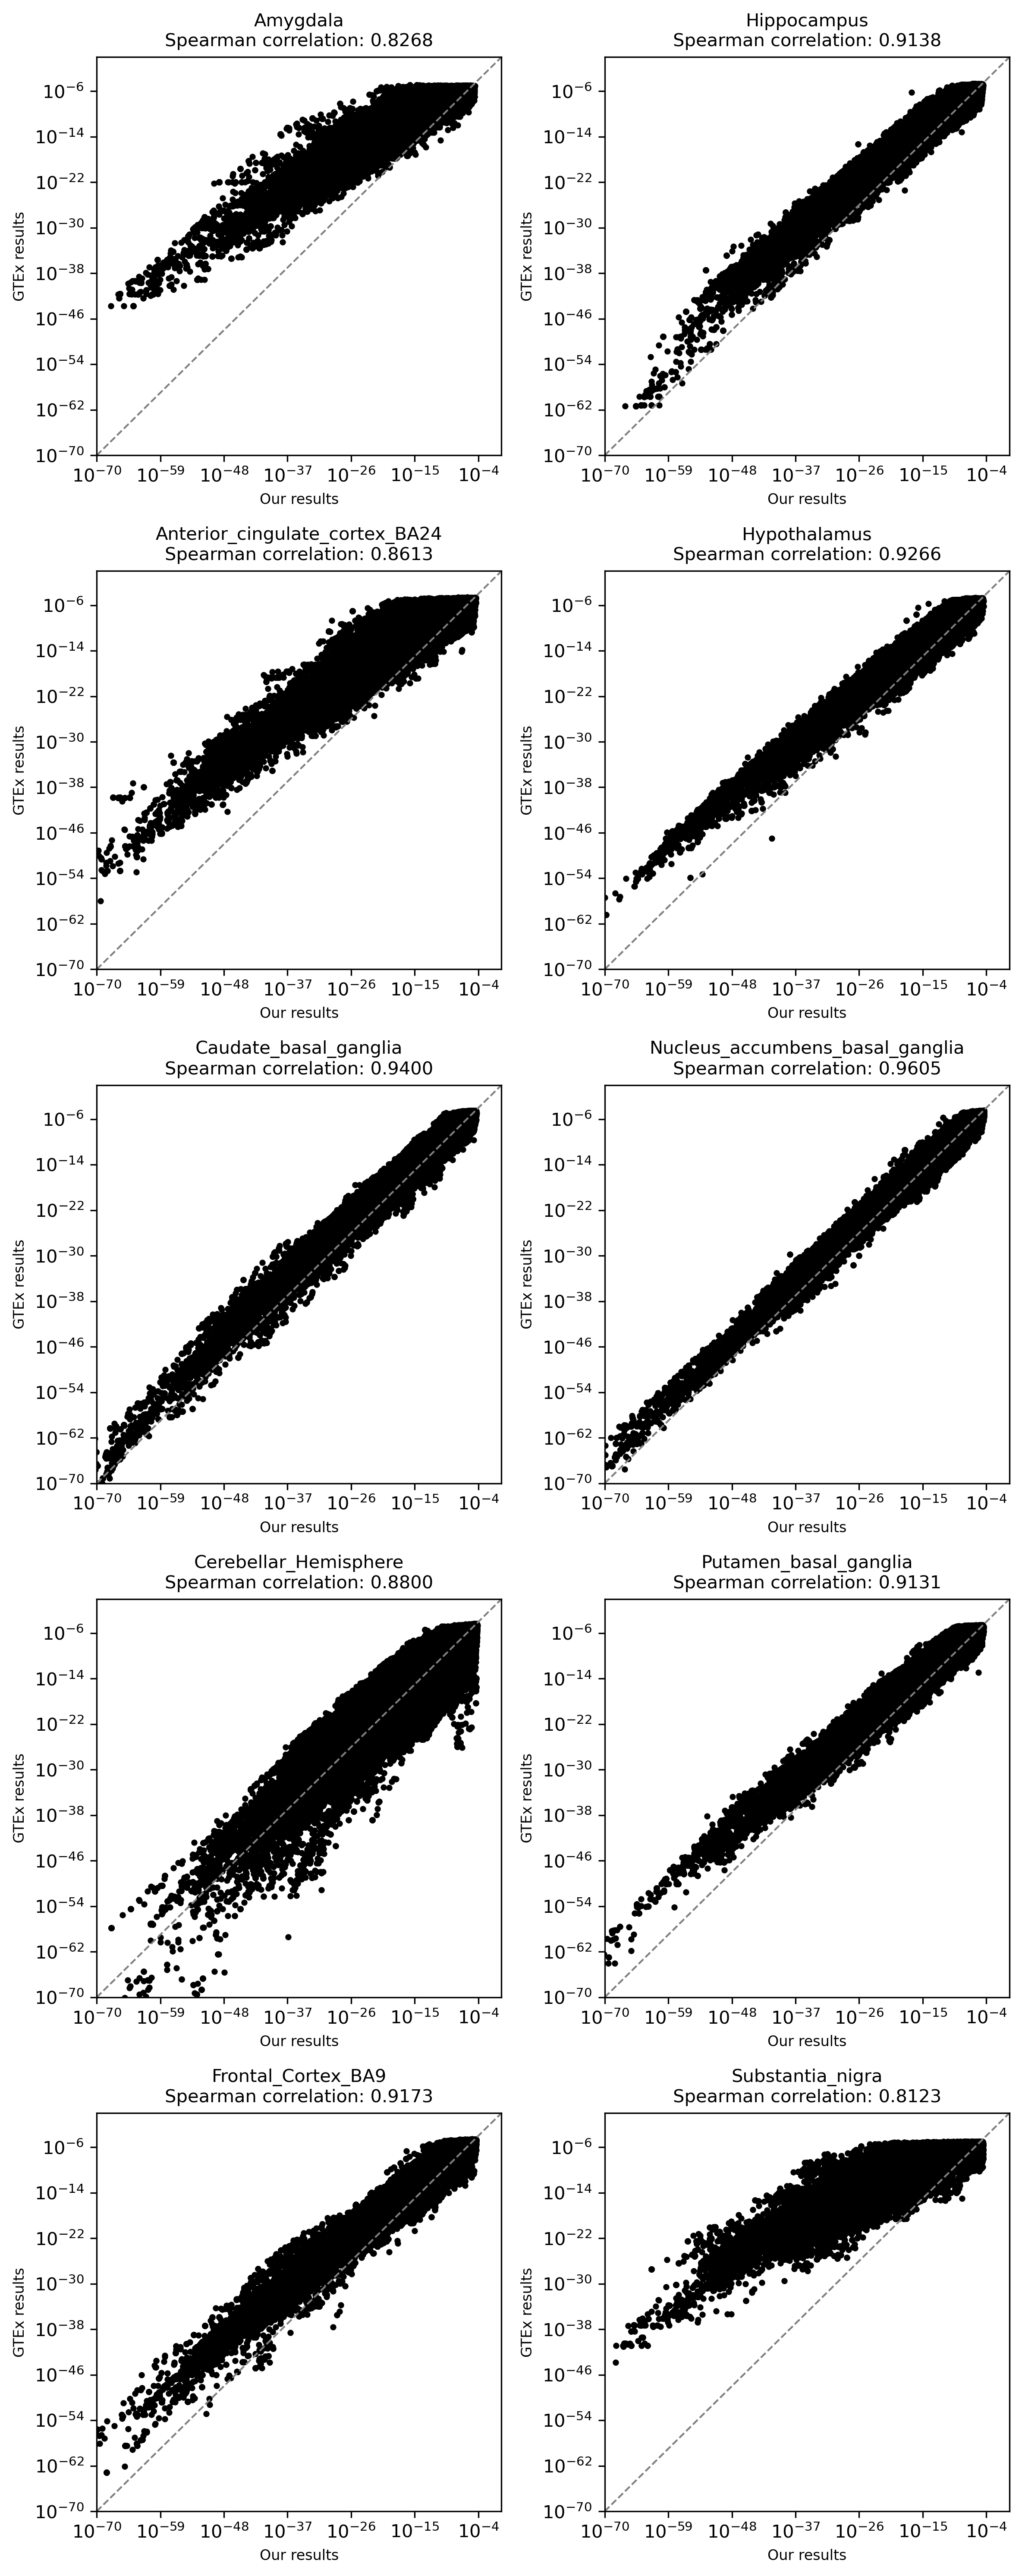

In [2]:
region_pick = [
    'Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia',
    'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus',
    'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra'
]

data_dir_our = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'
data_dir_gtex = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/Test_GTEx_fastQTL_results/'

fig, axes = plt.subplots(5, 2, figsize=(8, 20), dpi=300)  # Create a 5x2 grid

for i, picked_region in enumerate(region_pick):
    # Load our gene.txt
    our_egene = pd.read_csv(data_dir_our + picked_region + '.genes.txt.gz', delimiter='\t', compression='gzip')
    GTEx_egene = pd.read_csv(data_dir_gtex + picked_region + '.genes.txt.gz', delimiter='\t', compression='gzip')

    # Find overlapped genes
    overlapped_gene = list(set(our_egene['gene_id']) & set(GTEx_egene['gene_id']))

    # Load significant variant-gene pairs
    sig_var_gene_pairs = pd.read_csv(data_dir_our + picked_region + '.sig-gene-variant.csv')
    sig_var_gene_pairs_sub = sig_var_gene_pairs.loc[sig_var_gene_pairs['gene_id'].isin(overlapped_gene)].reset_index(drop=True)

    gtex_sig_var_gene = pd.read_csv(data_dir_gtex + picked_region + '.sig-gene-variant.csv')
    gtex_sig_var_gene_sub = gtex_sig_var_gene.loc[gtex_sig_var_gene['gene_id'].isin(overlapped_gene)].reset_index(drop=True)

    # Find overlapped eqtl genes
    overlapped_eqtl_gene = list(set(sig_var_gene_pairs_sub['gene_id']) & set(gtex_sig_var_gene_sub['gene_id']))
    our_eqtl_on_common_gene = sig_var_gene_pairs_sub.loc[sig_var_gene_pairs_sub['gene_id'].isin(overlapped_eqtl_gene)].reset_index(drop=True)
    gtex_eqtl_on_common_gene = gtex_sig_var_gene_sub.loc[gtex_sig_var_gene_sub['gene_id'].isin(overlapped_eqtl_gene)].reset_index(drop=True)

    # Overlapped var-gene pairs
    merge_df = pd.merge(our_eqtl_on_common_gene, gtex_eqtl_on_common_gene, on=['gene_id', 'variant_id', 'tss_distance'], how='inner')

    gtex_pval = merge_df['pval_nominal_y']
    our_pval = merge_df['pval_nominal_x']

    # Calculate Spearman correlation
    corr, _ = spearmanr(our_pval, gtex_pval)

    # Plot on the respective subplot
    ax = axes[i % 5, i // 5]  # Determine subplot location (5x2 grid)
    ax.scatter(our_pval, gtex_pval, color='black', marker='o', s=6)
    ax.plot([1e-70, 1e-0], [1e-70, 1e-0], linestyle='--', color='grey', linewidth=1)

    # Titles and labels
    ax.set_title(f'{picked_region}\nSpearman correlation: {corr:.4f}', fontsize=10)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-70, 1e-0)
    ax.set_ylim(1e-70, 1e-0)
    ax.set_xlabel('Our results', fontsize=8)
    ax.set_ylabel('GTEx results', fontsize=8)
    ax.grid(False)

# Adjust layout for better readability
plt.tight_layout()
plt.show()


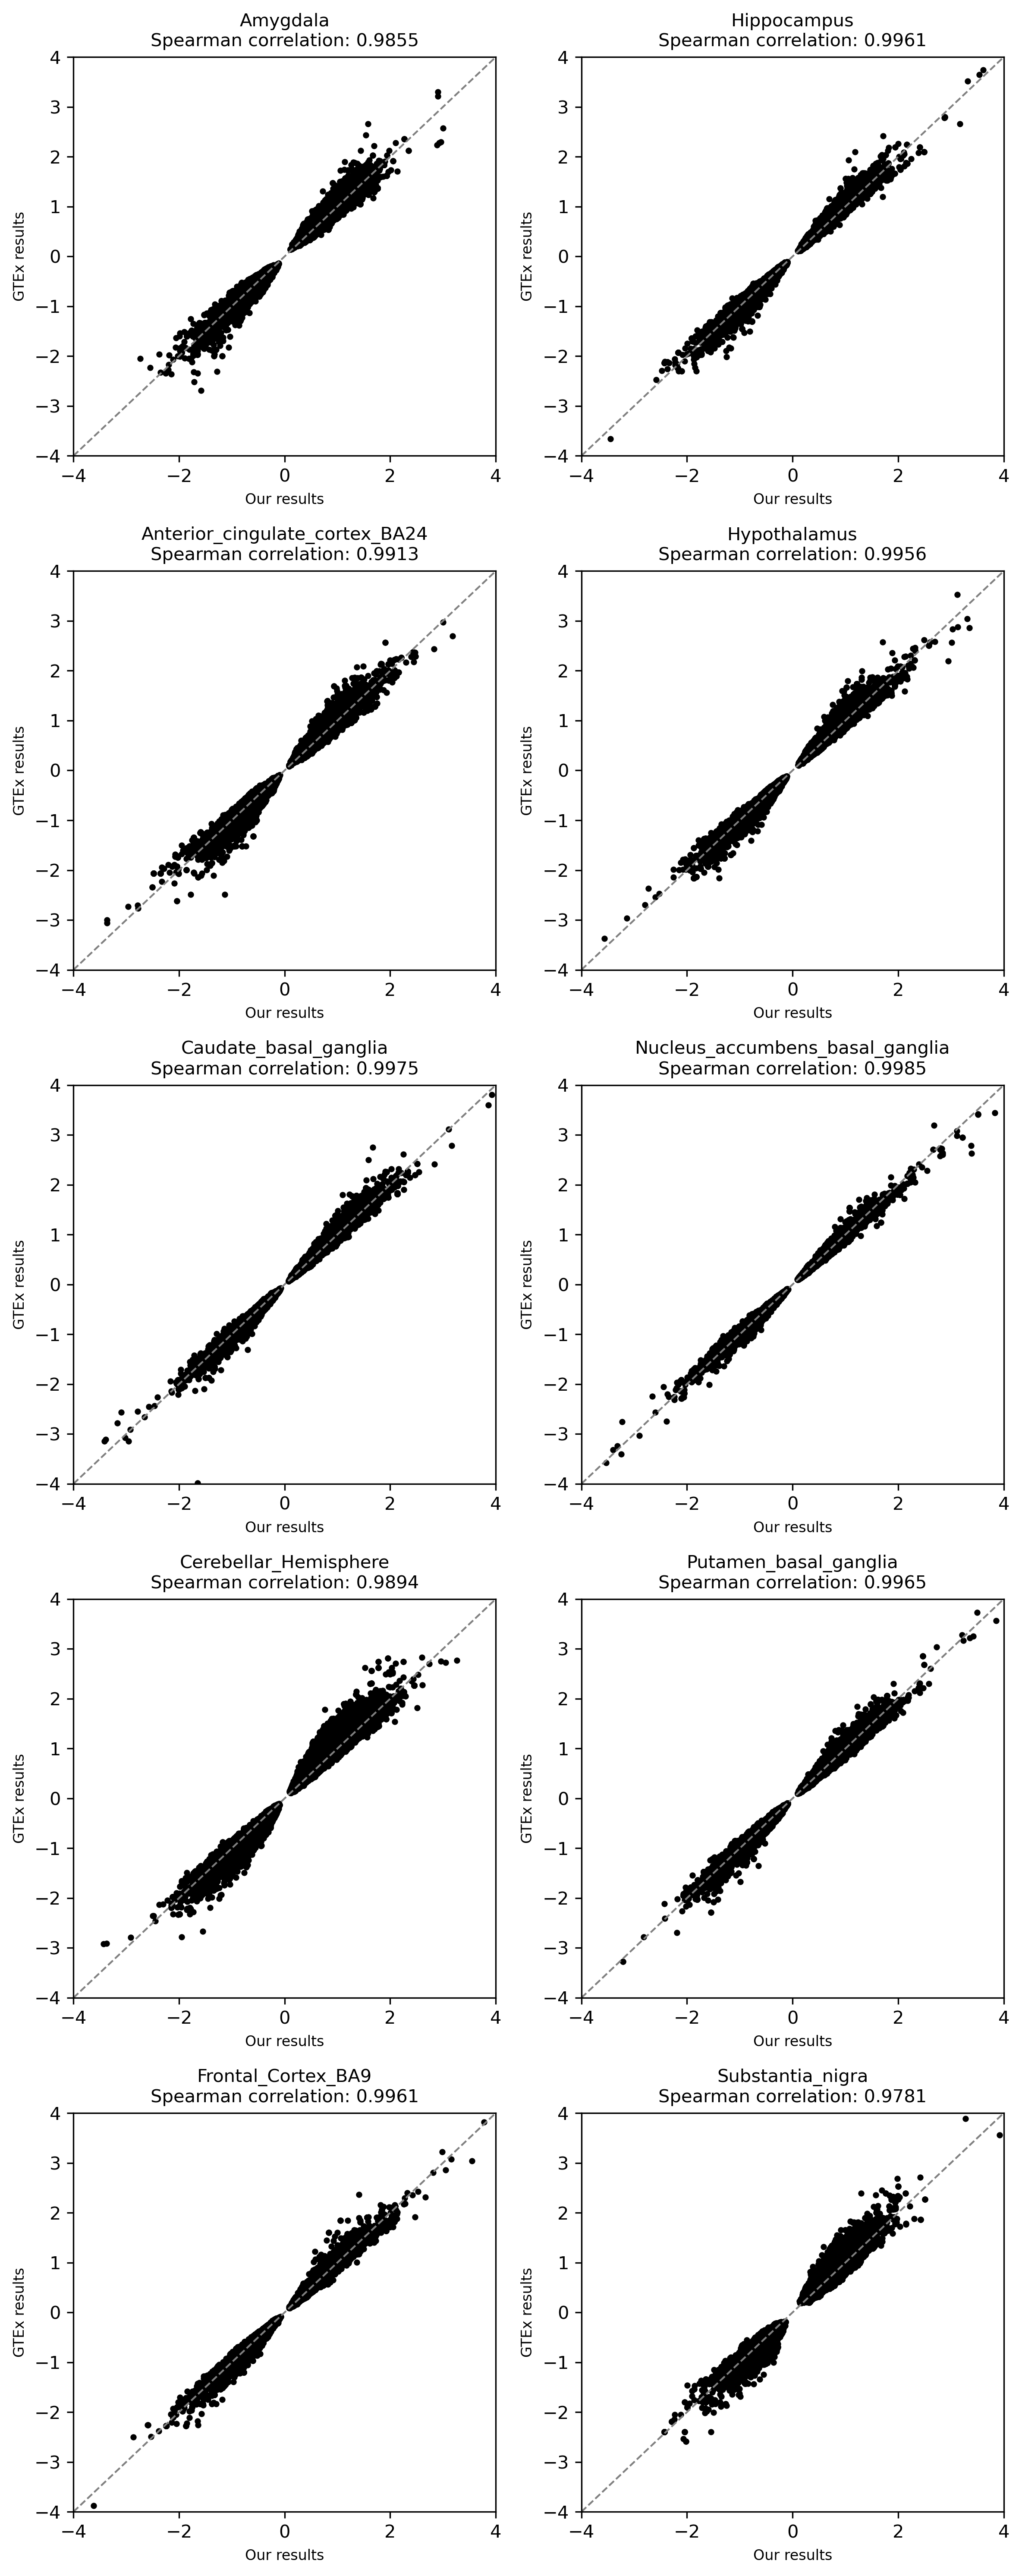

In [3]:
region_pick = [
    'Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia',
    'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus',
    'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra'
]

data_dir_our = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'
data_dir_gtex = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/Test_GTEx_fastQTL_results/'

fig, axes = plt.subplots(5, 2, figsize=(8, 20), dpi=300)  # Create a 5x2 grid

for i, picked_region in enumerate(region_pick):
    # Load our gene.txt
    our_egene = pd.read_csv(data_dir_our + picked_region + '.genes.txt.gz', delimiter='\t', compression='gzip')
    GTEx_egene = pd.read_csv(data_dir_gtex + picked_region + '.genes.txt.gz', delimiter='\t', compression='gzip')

    # Find overlapped genes
    overlapped_gene = list(set(our_egene['gene_id']) & set(GTEx_egene['gene_id']))

    # Load significant variant-gene pairs
    sig_var_gene_pairs = pd.read_csv(data_dir_our + picked_region + '.sig-gene-variant.csv')
    sig_var_gene_pairs_sub = sig_var_gene_pairs.loc[sig_var_gene_pairs['gene_id'].isin(overlapped_gene)].reset_index(drop=True)

    gtex_sig_var_gene = pd.read_csv(data_dir_gtex + picked_region + '.sig-gene-variant.csv')
    gtex_sig_var_gene_sub = gtex_sig_var_gene.loc[gtex_sig_var_gene['gene_id'].isin(overlapped_gene)].reset_index(drop=True)

    # Find overlapped eqtl genes
    overlapped_eqtl_gene = list(set(sig_var_gene_pairs_sub['gene_id']) & set(gtex_sig_var_gene_sub['gene_id']))
    our_eqtl_on_common_gene = sig_var_gene_pairs_sub.loc[sig_var_gene_pairs_sub['gene_id'].isin(overlapped_eqtl_gene)].reset_index(drop=True)
    gtex_eqtl_on_common_gene = gtex_sig_var_gene_sub.loc[gtex_sig_var_gene_sub['gene_id'].isin(overlapped_eqtl_gene)].reset_index(drop=True)

    # Overlapped var-gene pairs
    merge_df = pd.merge(our_eqtl_on_common_gene, gtex_eqtl_on_common_gene, on=['gene_id', 'variant_id', 'tss_distance'], how='inner')

    gtex_slope = merge_df['slope_y']
    our_slope = merge_df['slope_x']

    # Determine limits for the plot
    lim_range = 4  # Can be adjusted based on data range

    # Calculate Spearman correlation
    corr, _ = spearmanr(our_slope, gtex_slope)

    # Plot on the respective subplot
    ax = axes[i % 5, i // 5]  # Determine subplot location (5x2 grid)
    ax.scatter(our_slope, gtex_slope, color='black', marker='o', s=6)
    ax.plot([-lim_range, lim_range], [-lim_range, lim_range], linestyle='--', color='grey', linewidth=1)

    # Titles and labels
    ax.set_title(f'{picked_region}\nSpearman correlation: {corr:.4f}', fontsize=10)
    ax.set_xlim(-lim_range, lim_range)
    ax.set_ylim(-lim_range, lim_range)
    ax.set_xlabel('Our results', fontsize=8)
    ax.set_ylabel('GTEx results', fontsize=8)
    ax.grid(False)

# Adjust layout for better readability
plt.tight_layout()
plt.show()


## find all the rows with slope=0

In [10]:
# find significant ones in cmd
# module load miniconda/22.11.1-1
# conda activate fastqtl_env
# cd /project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/
# zcat Amygdala.allpairs.txt.gz | awk '{ if ($8 == 0) print }' > Amygdala.slope0.variant.txt
# zcat Amygdala.allpairs.txt.gz | awk '{ if ($6 == 0.5) print }' > Amygdala.maf05.variant.txt
# zcat Amygdala.allpairs.txt.gz | awk '{ if ($4 == $5) print }' > Amygdala.4equal5.variant.txt
# zcat Amygdala.allpairs.txt.gz | awk '{ if ($6 == 0.5 && $4 == $5) print }' > Amygdala.maf05_and_4equal5.variant.txt
# zcat Anterior_cingulate_cortex_BA24.allpairs.txt.gz | awk '{ if ($8 == 0) print }' > Anterior_cingulate_cortex_BA24.slope0.variant.txt

data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'
filename = 'Amygdala.slope0.variant.txt'
column_names = ['gene_id', 'variant_id', 'tss_distance', 'ma_samples', 'ma_count', 'maf', 'pval_nominal', 'slope', 'slope_se']
our_var_slope0 = pd.read_csv(data_dir+filename, delimiter='\t', names=column_names)
our_var_slope0

,gene_id,variant_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se
0,ENSG00000215914.4,chr1_2652211_A_G_b38,952269,1,1,0.5,1,0,NaN
1,ENSG00000215914.4,chr1_2653267_A_G_b38,953325,198,198,0.5,1,0,NaN
2,ENSG00000008130.15,chr1_2652211_A_G_b38,871754,1,1,0.5,1,0,NaN
3,ENSG00000008130.15,chr1_2653267_A_G_b38,872810,198,198,0.5,1,0,NaN
4,ENSG00000078369.17,chr1_2652211_A_G_b38,761094,1,1,0.5,1,0,NaN
...,...,...,...,...,...,...,...,...,...
85320,ENSG00000168939.11,chrX_155985435_T_C_b38,217623,198,198,0.5,1,0,NaN
85321,ENSG00000168939.11,chrX_155985447_T_C_b38,217635,198,198,0.5,1,0,NaN
85322,ENSG00000168939.11,chrX_155985470_A_G_b38,217658,198,198,0.5,1,0,NaN
85323,ENSG00000168939.11,chrX_155985886_G_A_b38,218074,198,198,0.5,1,0,NaN


In [12]:
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'
filename = 'Amygdala.maf05_and_4equal5.variant.txt'
column_names = ['gene_id', 'variant_id', 'tss_distance', 'ma_samples', 'ma_count', 'maf', 'pval_nominal', 'slope', 'slope_se']
df = pd.read_csv(data_dir+filename, delimiter='\t', names=column_names)
df

,gene_id,variant_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se
0,ENSG00000215914.4,chr1_2652211_A_G_b38,952269,1,1,0.5,1,0,NaN
1,ENSG00000215914.4,chr1_2653267_A_G_b38,953325,198,198,0.5,1,0,NaN
2,ENSG00000008130.15,chr1_2652211_A_G_b38,871754,1,1,0.5,1,0,NaN
3,ENSG00000008130.15,chr1_2653267_A_G_b38,872810,198,198,0.5,1,0,NaN
4,ENSG00000078369.17,chr1_2652211_A_G_b38,761094,1,1,0.5,1,0,NaN
...,...,...,...,...,...,...,...,...,...
85320,ENSG00000168939.11,chrX_155985435_T_C_b38,217623,198,198,0.5,1,0,NaN
85321,ENSG00000168939.11,chrX_155985447_T_C_b38,217635,198,198,0.5,1,0,NaN
85322,ENSG00000168939.11,chrX_155985470_A_G_b38,217658,198,198,0.5,1,0,NaN
85323,ENSG00000168939.11,chrX_155985886_G_A_b38,218074,198,198,0.5,1,0,NaN


### see how the merge goes

In [14]:
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_for_allen_regions/running_mashr/small_allpairs_folder/'
filename = 'merged_file.txt'
df = pd.read_csv(data_dir+filename, delimiter='\t')
df

,gene_id,variant_id,13005,4012
0,ENSG00000000003.14,chrX_100694736_A_G_b38,0.141873,-0.170027
1,ENSG00000000005.5,chrX_100338306_C_T_b38,0.090778,0.105383
2,ENSG00000000419.12,chr20_51266493_T_C_b38,-0.071857,-0.022580
3,ENSG00000000457.13,chr1_170067262_T_A_b38,-0.201422,-0.017625
4,ENSG00000000460.16,chr1_169213331_T_A_b38,0.049511,0.023303
...,...,...,...,...
19483,ENSG00000283945.1,chr9_27813697_A_G_b38,0.021542,-0.147466
19484,ENSG00000283992.1,chr8_141883779_G_A_b38,0.284395,-0.374084
19485,ENSG00000283992.1,chr8_143210831_G_A_b38,0.084074,-0.028556
19486,ENSG00000284308.1,chr2_75132852_C_G_b38,-0.144468,0.196382


In [ ]:
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_for_allen_regions/running_mashr/small_allpairs_folder/'
filename = 'merged_file.txt'
df = pd.read_csv(data_dir+filename, delimiter='\t')
df

## Compare our new discovered eqtls with PsychENCODE

In [2]:
# read the results from PsychENCODE and HYFA
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/HYFA and PsychENCODE/'
filename = 'DER-08a_hg38_eQTL.significant.txt'
PsychENCODE_results = pd.read_csv(data_dir+filename, sep='\t')
filename = 'Ramon_observed_and_imputed_Brain_Frontal_Cortex_matrixEQTL_Output_EQTLs_With_Covariates.new.FDR0.1.txt'
HYFA_results = pd.read_csv(data_dir+filename, sep='\t')
# ensg id to gene id match file
match_file = '/project/pi_rachel_melamed_uml_edu/adni/data/ensg2gene_name.txt'
ensg2gene = pd.read_csv(match_file, sep='\t')
ensg2gene.columns = ["gene_id", "gene_name"]

# find the gene_id for HYFA
HYFA_results = pd.merge(HYFA_results, ensg2gene[['gene_id', 'gene_name']], 
                        how='left', left_on='gene', right_on='gene_name')
na_rows = HYFA_results[HYFA_results.isna().any(axis=1)]
print(f"Number of total rows in HYFA: {HYFA_results.shape[0]}")
print(f"Number of rows in HYFA with missing gene_id: {len(na_rows)}")

Number of total rows in HYFA: 639987
Number of rows in HYFA with missing gene_id: 172015


#### Analyse the overlapped between HYFA and PsychENCODE

In [3]:
HYFA_results['SNP_id'] = HYFA_results['SNP'].str.extract(r'chr(\d+)_([\d]+)_')[0] + ':' + HYFA_results['SNP'].str.extract(r'chr(\d+)_([\d]+)_')[1]
# Perform an inner join on both 'gene_id' and 'SNP_id' / 'our_SNP_id'
merged_df = pd.merge(PsychENCODE_results, HYFA_results, 
                     how='inner', 
                     left_on=['gene_id', 'SNP_id'], 
                     right_on=['gene_id', 'SNP_id'])

# Get the number of matching rows
matching_rows = merged_df.shape[0]
# Display the result
print(f"Number of matching rows: {matching_rows}")

Number of matching rows: 1073


In [4]:
merged_df

,gene_id,gene_chr,gene_start,gene_end,strand,number_of_SNPs_tested,SNP_distance_to_TSS,SNP_id,SNP_chr,SNP_start,...,regression_slope,top_SNP,FDR_x,SNP,gene,beta,t-stat,p-value,FDR_y,gene_name
0,ENSG00000167653.4,chr8,142670308,142670308,+,4876,1268,8:142671576,chr8,142671576,...,0.319323,0,0.000000e+00,chr8_142671576_T_C_b38,PSCA,0.145555,6.374604,3.069978e-10,0.001402,PSCA
1,ENSG00000167653.4,chr8,142670308,142670308,+,4876,1563,8:142671871,chr8,142671871,...,-0.248242,0,9.000000e-16,chr8_142671871_C_T_b38,PSCA,-0.130642,-5.735033,1.374007e-08,0.017016,PSCA
2,ENSG00000167653.4,chr8,142670308,142670308,+,4876,3002,8:142673310,chr8,142673310,...,0.326219,1,0.000000e+00,chr8_142673310_G_A_b38,PSCA,0.146601,6.434062,2.118506e-10,0.001061,PSCA
3,ENSG00000167653.4,chr8,142670308,142670308,+,4876,4492,8:142674800,chr8,142674800,...,0.319007,0,0.000000e+00,chr8_142674800_G_C_b38,PSCA,0.145604,6.402647,2.578170e-10,0.001225,PSCA
4,ENSG00000167653.4,chr8,142670308,142670308,+,4876,4804,8:142675112,chr8,142675112,...,0.317943,0,0.000000e+00,chr8_142675112_T_C_b38,PSCA,0.145604,6.402647,2.578170e-10,0.001225,PSCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,ENSG00000127578.6,chr16,629239,629239,+,2863,-2219,16:627020,chr16,627020,...,0.405936,0,0.000000e+00,chr16_627020_G_T_b38,WFIKKN1,0.175703,5.732418,1.394528e-08,0.017166,WFIKKN1
1069,ENSG00000127578.6,chr16,629239,629239,+,2863,-396,16:628843,chr16,628843,...,0.406360,0,0.000000e+00,chr16_628843_C_T_b38,WFIKKN1,0.171004,5.614334,2.707164e-08,0.024999,WFIKKN1
1070,ENSG00000127578.6,chr16,629239,629239,+,2863,35,16:629274,chr16,629274,...,0.407388,1,0.000000e+00,chr16_629274_G_A_b38,WFIKKN1,0.175863,5.798167,9.588774e-09,0.013740,WFIKKN1
1071,ENSG00000127578.6,chr16,629239,629239,+,2863,1335,16:630574,chr16,630574,...,0.384092,0,0.000000e+00,chr16_630574_G_A_b38,WFIKKN1,0.178188,5.741488,1.324598e-08,0.016629,WFIKKN1


#### Other analysis

In [5]:
HYFA_results

,SNP,gene,beta,t-stat,p-value,FDR,gene_id,gene_name,SNP_id
0,chr20_1908219_A_G_b38,SIRPB1,0.251009,11.673194,3.211566e-29,4.427723e-19,ENSG00000101307.15,SIRPB1,20:1908219
1,chr20_1913669_C_T_b38,SIRPB1,0.251370,11.645949,4.224647e-29,4.427723e-19,ENSG00000101307.15,SIRPB1,20:1913669
2,chr20_1913163_G_A_b38,SIRPB1,0.251079,11.638512,4.552587e-29,4.427723e-19,ENSG00000101307.15,SIRPB1,20:1913163
3,chr20_1914975_C_A_b38,SIRPB1,0.250902,11.627912,5.064174e-29,4.427723e-19,ENSG00000101307.15,SIRPB1,20:1914975
4,chr20_1914984_T_C_b38,SIRPB1,0.250902,11.627912,5.064174e-29,4.427723e-19,ENSG00000101307.15,SIRPB1,20:1914984
...,...,...,...,...,...,...,...,...,...
639982,chr18_51154196_G_T_b38,ABCA2,-0.396918,-5.078021,4.730393e-07,9.999814e-02,ENSG00000107331.16,ABCA2,18:51154196
639983,chr18_51154885_C_T_b38,ABCA2,-0.396918,-5.078021,4.730393e-07,9.999814e-02,ENSG00000107331.16,ABCA2,18:51154885
639984,chr11_119994166_T_C_b38,TMEM231,-0.509680,-5.078019,4.730441e-07,9.999902e-02,ENSG00000205084.10,TMEM231,11:119994166
639985,chr9_105416834_T_G_b38,NEXN,-0.300076,-5.078018,4.730452e-07,9.999910e-02,ENSG00000162614.18,NEXN,9:105416834


In [6]:
## PsychENCODE eqtl results are downloaded here:
# QTL Maps 2.b, version hg38

# load our results
region = 'Frontal_Cortex_BA9'

##### find the overlapped genes
# our gene.txt
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'
filename = 'Amygdala.genes.txt.gz'
our_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
# raed GTEx egene.txt
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/Test_GTEx_fastQTL_results/'
filename = 'Amygdala.genes.txt.gz'
GTEx_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
# find overlapeed genes
overlapped_gene = list(set(our_egene['gene_id']) & set(GTEx_egene['gene_id']))

##### GTEx reproduced results on overlapped genes
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/Test_GTEx_fastQTL_results/'
filename = region+'.sig-gene-variant.csv'
gtex_sig_var_gene = pd.read_csv(data_dir+filename)
gtex_sig_var_gene_sub = gtex_sig_var_gene.loc[gtex_sig_var_gene['gene_id'].isin(overlapped_gene)].reset_index(drop=True)

##### our results on overlapped genes
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_results/'
filename = region+'.sig-gene-variant.csv'
sig_var_gene_pairs = pd.read_csv(data_dir+filename)
sig_var_gene_pairs_sub = sig_var_gene_pairs.loc[sig_var_gene_pairs['gene_id'].isin(overlapped_gene)].reset_index(drop=True)

# new found eqtl-eGene pairs
sig_vars = sig_var_gene_pairs_sub[['gene_id', 'variant_id']]
gtex_vars = gtex_sig_var_gene_sub[['gene_id', 'variant_id']]
new_discovered_pairs = pd.merge(sig_var_gene_pairs_sub, gtex_sig_var_gene_sub[['gene_id', 'variant_id']], 
                                how='left', on=['gene_id', 'variant_id'], indicator=True)
new_discovered_pairs = new_discovered_pairs[new_discovered_pairs['_merge'] == 'left_only'].drop('_merge', axis=1)
# overlapeed eqtl-eGene pairs
overlapped_pairs = pd.merge(sig_var_gene_pairs_sub, gtex_sig_var_gene_sub[['gene_id', 'variant_id']], 
                            how='inner', on=['gene_id', 'variant_id'])

In [7]:
sig_var_gene_pairs_sub

,gene_id,variant_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se,pval_nominal_threshold,min_pval_nominal,pval_beta
0,ENSG00000225880.5,chr1_605777_GA_G_b38,-221745,24,24,0.057692,6.828680e-07,0.822261,0.159392,0.000018,3.505760e-16,3.019390e-12
1,ENSG00000225880.5,chr1_722408_G_C_b38,-105114,70,81,0.191943,2.190600e-06,-0.508299,0.103690,0.000018,3.505760e-16,3.019390e-12
2,ENSG00000225880.5,chr1_726821_G_A_b38,-100701,59,71,0.170673,3.699970e-07,-0.502026,0.094896,0.000018,3.505760e-16,3.019390e-12
3,ENSG00000225880.5,chr1_727242_G_A_b38,-100280,50,53,0.126190,1.461140e-07,0.609463,0.111100,0.000018,3.505760e-16,3.019390e-12
4,ENSG00000225880.5,chr1_727477_G_A_b38,-100045,63,73,0.172986,1.170770e-05,-0.481764,0.106682,0.000018,3.505760e-16,3.019390e-12
...,...,...,...,...,...,...,...,...,...,...,...,...
560632,ENSG00000155961.4,chrX_155668207_G_A_b38,403618,73,116,0.276190,3.571800e-05,0.117991,0.027792,0.000038,6.605160e-06,1.631590e-02
560633,ENSG00000155961.4,chrX_155696234_C_T_b38,431645,72,107,0.253554,3.056800e-05,-0.124034,0.028953,0.000038,6.605160e-06,1.631590e-02
560634,ENSG00000185973.10,chrX_155346593_T_TTTCTTTCTTTC_b38,-323351,5,5,0.011848,1.154260e-05,-1.429170,0.316239,0.000052,1.154260e-05,2.674370e-02
560635,ENSG00000185973.10,chrX_155396696_TTTCTTC_T_b38,-273248,77,133,0.337563,4.726750e-05,-0.215682,0.051653,0.000052,1.154260e-05,2.674370e-02


In [8]:
### Comparing with HYFA
merged_df = pd.merge(HYFA_results, overlapped_pairs, 
                     how='inner', 
                     left_on=['gene_id', 'SNP'], 
                     right_on=['gene_id', 'variant_id'])

# Display the result
print(f"Number of eQTL-eGene pairs in HYFA: {HYFA_results.shape[0]}")
print(f"Number of eQTL-eGene pairs in recovered_GTEx: {overlapped_pairs.shape[0]}")
print(f"Number of matching eQTL-eGene pairs between HYFA and recovered_GTEx: {merged_df.shape[0]}")

Number of eQTL-eGene pairs in HYFA: 639987
Number of eQTL-eGene pairs in recovered_GTEx: 383322
Number of matching eQTL-eGene pairs between HYFA and recovered_GTEx: 18698


In [9]:
merged_df = pd.merge(HYFA_results, new_discovered_pairs, 
                     how='inner', 
                     left_on=['gene_id', 'SNP'], 
                     right_on=['gene_id', 'variant_id'])

# Display the result
print(f"Number of eQTL-eGene pairs in HYFA: {HYFA_results.shape[0]}")
print(f"Number of eQTL-eGene pairs in new predicted: {new_discovered_pairs.shape[0]}")
print(f"Number of matching eQTL-eGene pairs between HYFA and our new predicted: {merged_df.shape[0]}")

Number of eQTL-eGene pairs in HYFA: 639987
Number of eQTL-eGene pairs in new predicted: 177315
Number of matching eQTL-eGene pairs between HYFA and our new predicted: 159


In [10]:
### Comparing with PsychENCODE
# Extract the chromosome and position from the 'variant_id' column and create the new 'our_SNP_id' column
overlapped_pairs['our_SNP_id'] = overlapped_pairs['variant_id'].str.extract(r'chr(\d+)_([\d]+)_')[0] + ':' + overlapped_pairs['variant_id'].str.extract(r'chr(\d+)_([\d]+)_')[1]
# Perform an inner join on both 'gene_id' and 'SNP_id' / 'our_SNP_id'
merged_df = pd.merge(PsychENCODE_results, overlapped_pairs, 
                     how='inner', 
                     left_on=['gene_id', 'SNP_id'], 
                     right_on=['gene_id', 'our_SNP_id'])

# Display the result
print(f"Number of eQTL-eGene pairs in PsychENCODE: {PsychENCODE_results.shape[0]}")
print(f"Number of eQTL-eGene pairs in recovered_GTEx: {overlapped_pairs.shape[0]}")
print(f"Number of matching eQTL-eGene pairs between Psych and recovered_GTEx: {merged_df.shape[0]}")

Number of eQTL-eGene pairs in PsychENCODE: 2542119
Number of eQTL-eGene pairs in recovered_GTEx: 383322
Number of matching eQTL-eGene pairs between Psych and recovered_GTEx: 10418


In [11]:
# Extract the chromosome and position from the 'variant_id' column and create the new 'our_SNP_id' column
new_discovered_pairs['our_SNP_id'] = new_discovered_pairs['variant_id'].str.extract(r'chr(\d+)_([\d]+)_')[0] + ':' + new_discovered_pairs['variant_id'].str.extract(r'chr(\d+)_([\d]+)_')[1]
# Perform an inner join on both 'gene_id' and 'SNP_id' / 'our_SNP_id'
merged_df = pd.merge(PsychENCODE_results, new_discovered_pairs, 
                     how='inner', 
                     left_on=['gene_id', 'SNP_id'], 
                     right_on=['gene_id', 'our_SNP_id'])

# Display the result
print(f"Number of eQTL-eGene pairs in PsychENCODE: {PsychENCODE_results.shape[0]}")
print(f"Number of eQTL-eGene pairs in new predicted GTEx: {new_discovered_pairs.shape[0]}")
print(f"Number of matching eQTL-eGene pairs between Psych and our new predicted: {merged_df.shape[0]}")

Number of eQTL-eGene pairs in PsychENCODE: 2542119
Number of eQTL-eGene pairs in recovered_GTEx: 177315
Number of matching eQTL-eGene pairs between Psych and our new predicted: 4088
